In [3]:
import matplotlib.pyplot as plt
import xarray as xr
from vesuvius.data_io import read_dataset_from_zarr

from training import *


try:
    from typing import Protocol
except ImportError:
    from typing_extensions import Protocol

dask.config.set(scheduler='synchronous')

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

/home/john/.local/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/john/.local/lib/python3.10/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


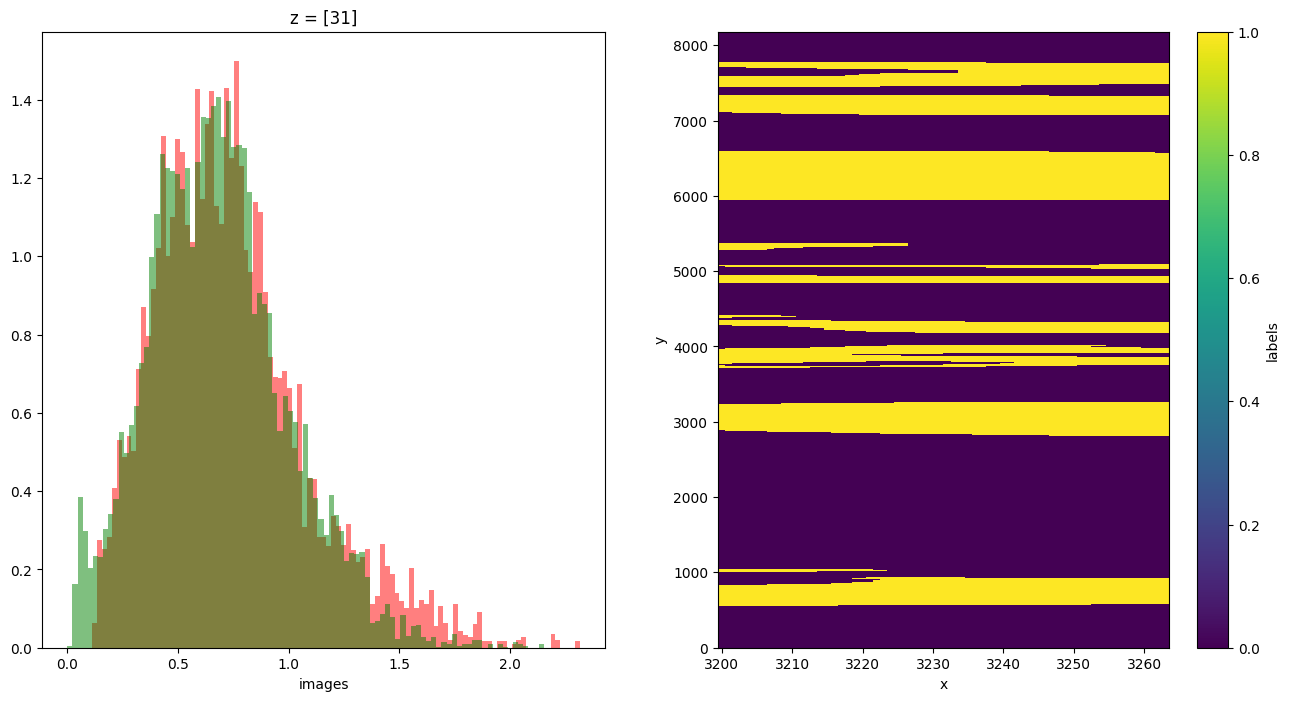

In [5]:
dsn = read_dataset_from_zarr(1, 5, config1.prefix)
start_x = 3200
cross_y = dsn.isel(x=slice(start_x,  start_x + 64), y=slice(None, None))
cross_y = cross_y.isel(z=slice(31, 32))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
cross_y.images.std(dim='x').where(cross_y.labels & cross_y.mask).plot.hist(ax=ax1, bins=100, color='red', alpha=0.5, density=True);
cross_y.images.std(dim='x').where(~cross_y.labels & cross_y.mask).plot.hist(ax=ax1, bins=100, color='green', alpha=0.5, density=True);
cross_y.labels.plot.imshow(ax=ax2);

In [104]:
2**13

8192

/home/john/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/john/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


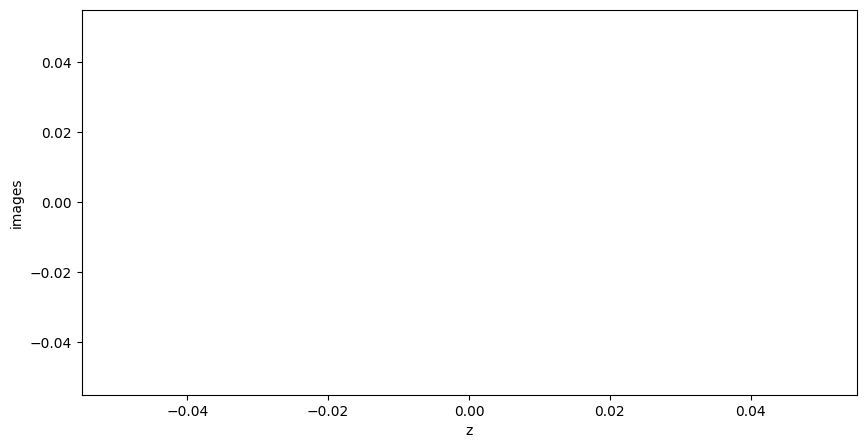

/home/john/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/john/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


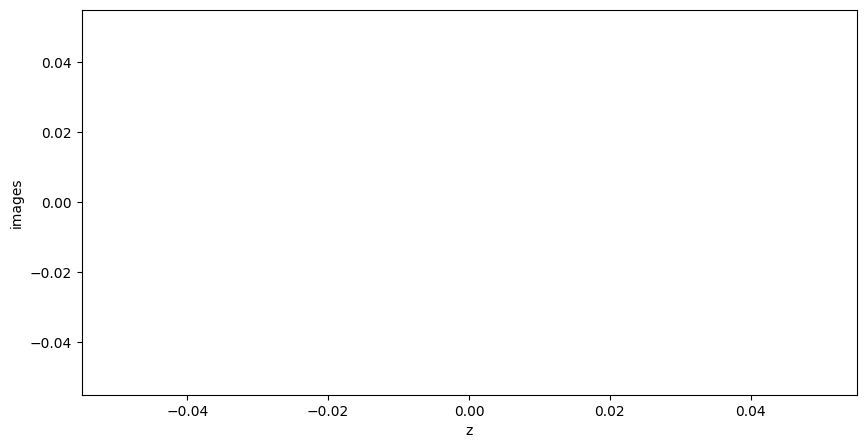

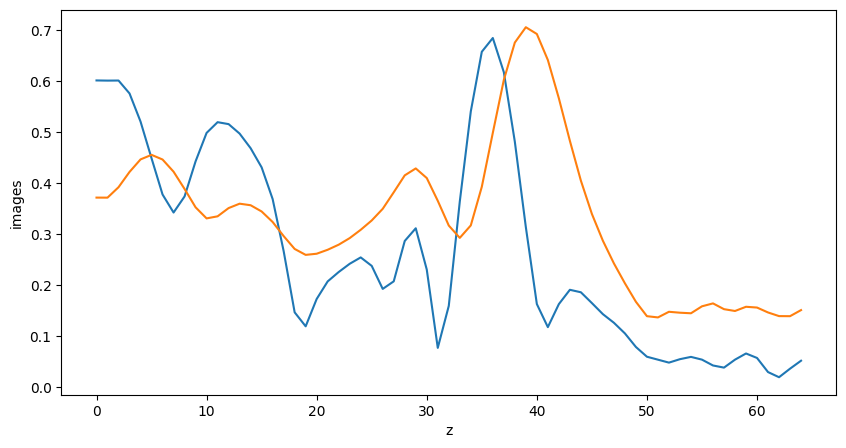

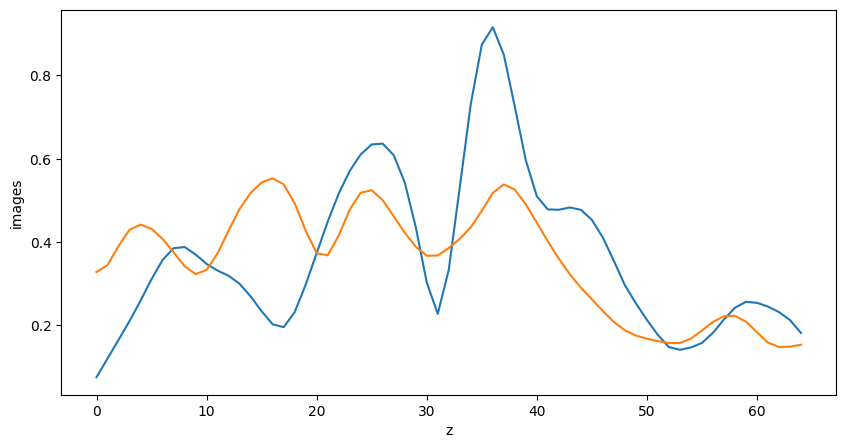

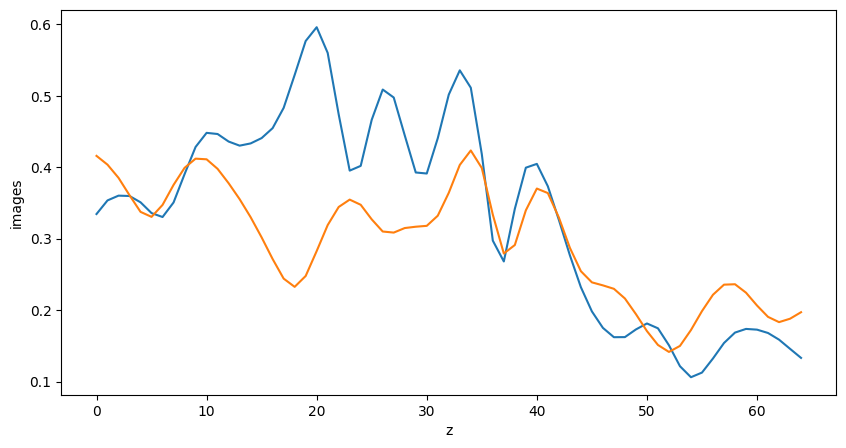

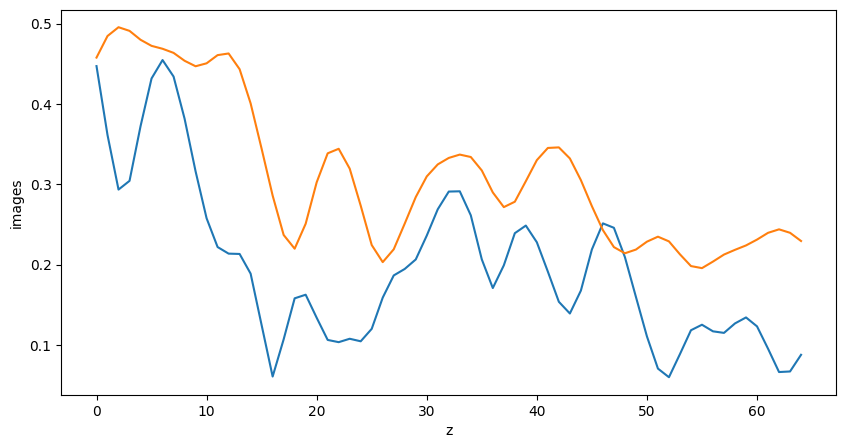

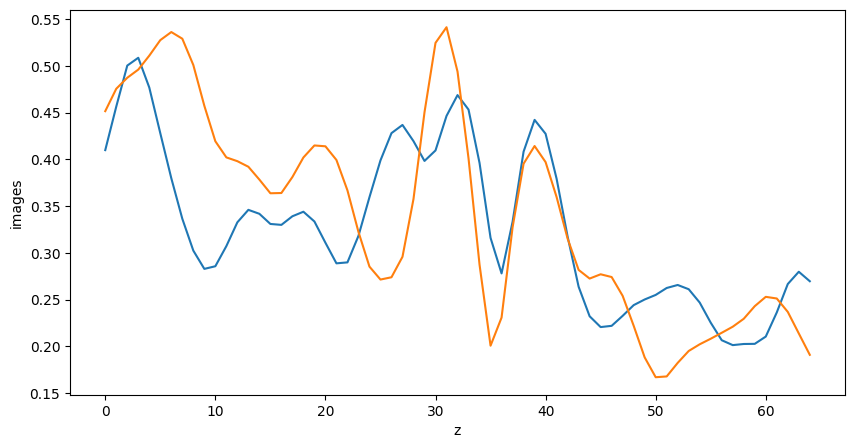

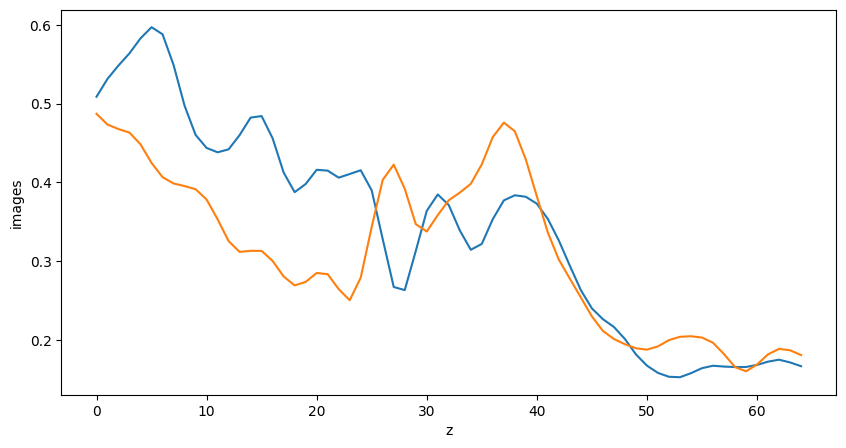

In [250]:
for start_y in range(0, 2**13, 1024):
    start_x = 1024
    big_window = 516
    window_size = 64
    ds = read_dataset_from_zarr(1, 5, config.prefix).isel(x=slice(start_x, start_x + big_window), y=slice(start_y, start_y + big_window))
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        images_coarse = ds['images'].coarsen(x=window_size, y=window_size, boundary='trim').mean()
        mask_coarse = ds['mask'].coarsen(x=window_size, y=window_size, boundary='trim').mean()
        labels_coarse = ds['labels'].coarsen(x=window_size, y=window_size, boundary='trim').mean()
    mask_coarse = mask_coarse.astype(bool)
    labels_coarse = labels_coarse.astype(bool)
    ds['images'] = images_coarse
    ds['mask'] = mask_coarse
    ds['labels'] = labels_coarse
    ds_coarse = xr.Dataset({'images': images_coarse, 'mask': mask_coarse, 'labels': labels_coarse})
    ds_coarse = ds_coarse.compute()
    # ds_coarse.labels.plot.imshow()
    #
    # fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
    # ink_stds = []
    # blk_stds = []
    # for x_sel in ds_coarse.labels.x:
    #     ink_std = ds_coarse.where(ds_coarse.labels).images.sel(x=x_sel, method='nearest').mean(dim='y')
    #     ink_std.plot(color='red', alpha=0.5)
    #     ink_stds.append(ink_std.values)
    #     blk_std = ds_coarse.where(~ds_coarse.labels).images.sel(x=x_sel, method='nearest').mean(dim='y')
    #     blk_std.plot(color='green', alpha=0.5)
    #     blk_stds.append(blk_std.values)
    #     ds_coarse.labels.plot.imshow(ax=ax2, add_colorbar=False);
    # plt.show()
    #
    #
    ds_coarse_stack = ds_coarse.where(ds_coarse.mask).stack(p=('x', 'y'))
    # fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
    # ds_coarse_stack.images.where(ds_coarse_stack.labels.astype(bool)).mean(dim='p').plot(ax=ax1)
    # ds_coarse_stack.images.where(~ds_coarse_stack.labels.astype(bool)).mean(dim='p').plot(ax=ax1)
    # plt.show()
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
    ds_coarse_stack.images.where(ds_coarse_stack.labels.astype(bool)).std(dim='p').plot(ax=ax1)
    ds_coarse_stack.images.where(~ds_coarse_stack.labels.astype(bool)).std(dim='p').plot(ax=ax1)
    plt.show()

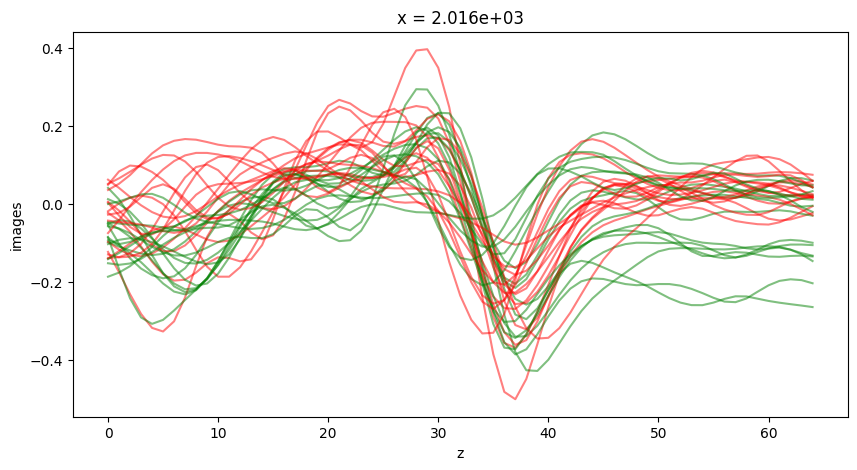

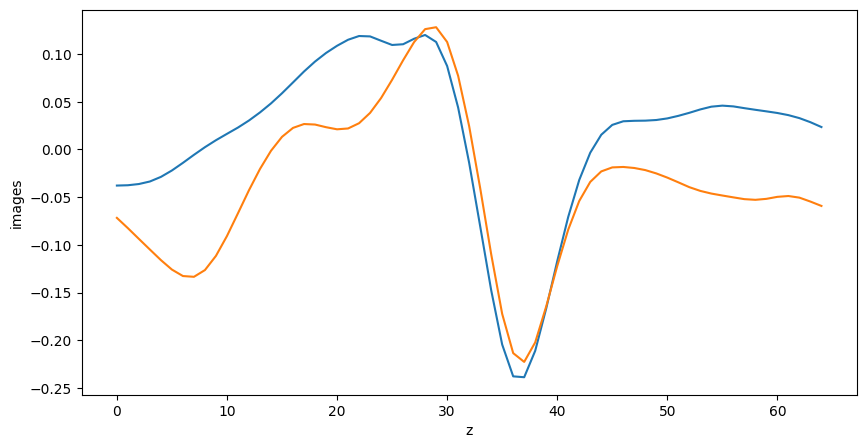

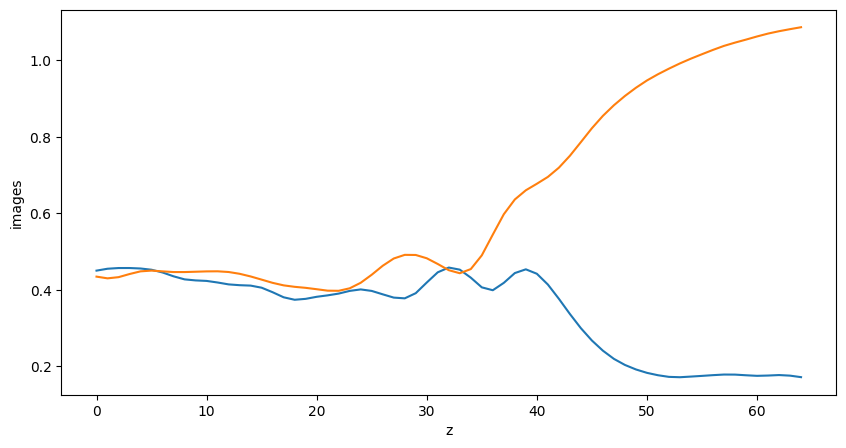

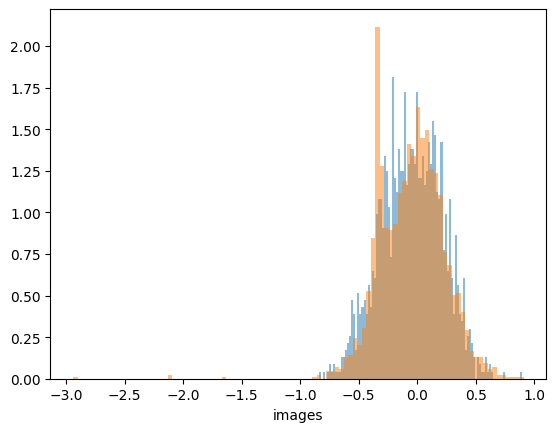

In [108]:
ds_coarse.images.where(ds_coarse.labels).isel(z=slice(25, 35)).mean(dim='z').plot.hist(alpha=0.5, density=True, bins=100);
ds_coarse.images.where(~ds_coarse.labels).isel(z=slice(25, 35)).mean(dim='z').plot.hist(alpha=0.5, density=True, bins=100);

In [197]:
ds_coarse_stack.labels.astype(bool).all()

<xarray.DataArray 'labels' ()>
array(True)

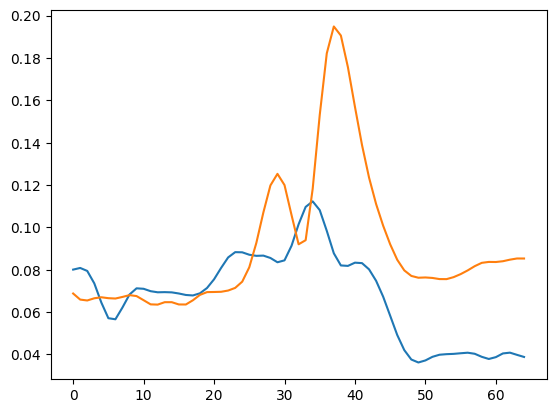

In [172]:
import pandas as pd

ink_stds_mean = pd.DataFrame(ink_stds).std().plot()
blk_stds_mean = pd.DataFrame(blk_stds).std().plot()

ValueError: x and y must have same first dimension, but have shapes (21,) and (19,)

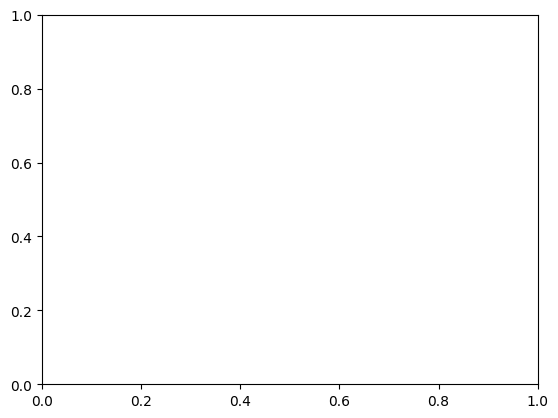

In [144]:
def norm_hist(filt):
    y , x, _ = dsn.images.where(filt).plot.hist(ax=ax, bins=20, color='yellow', alpha=.5)
    y / (filt).sum().item()
    return plt.plot(x, y[1:])

norm_hist(~d.labels & d.mask)

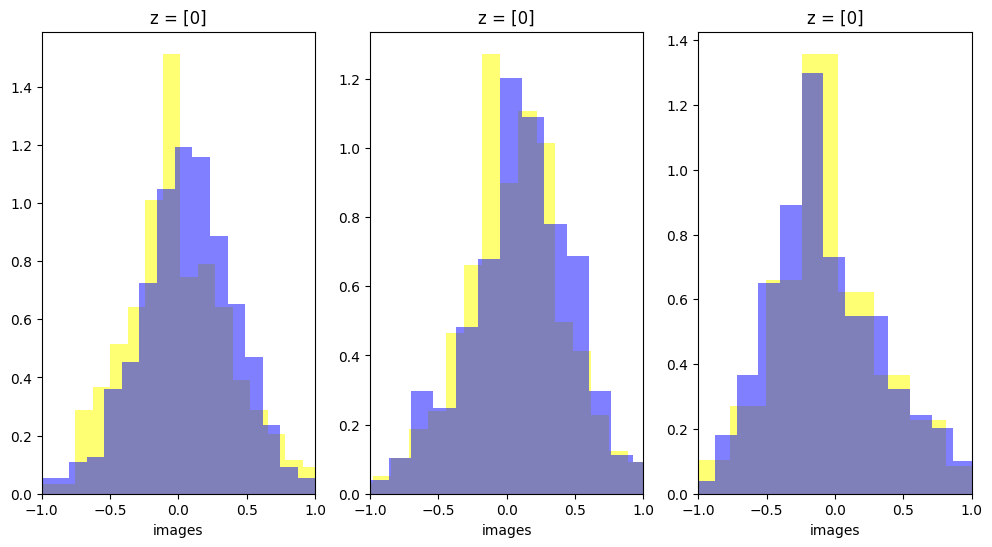

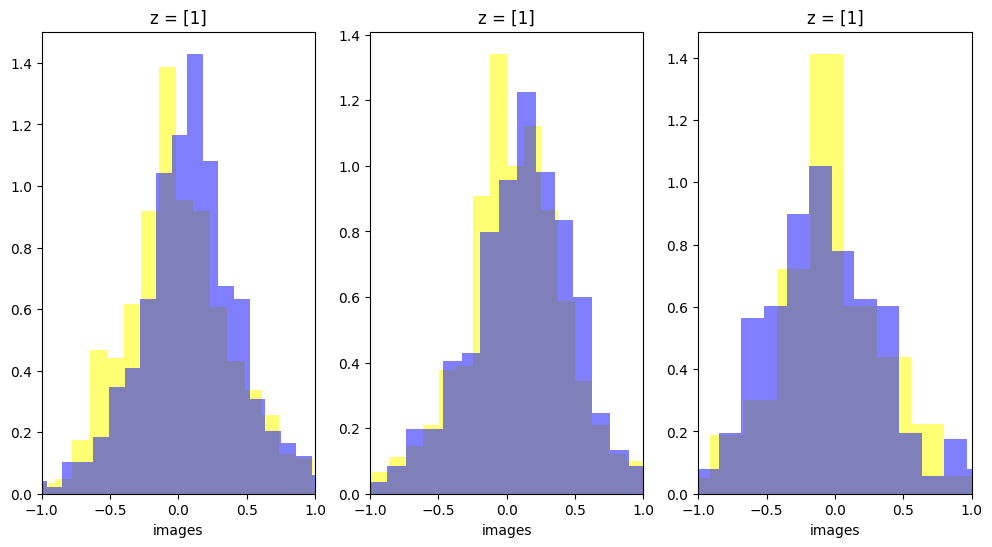

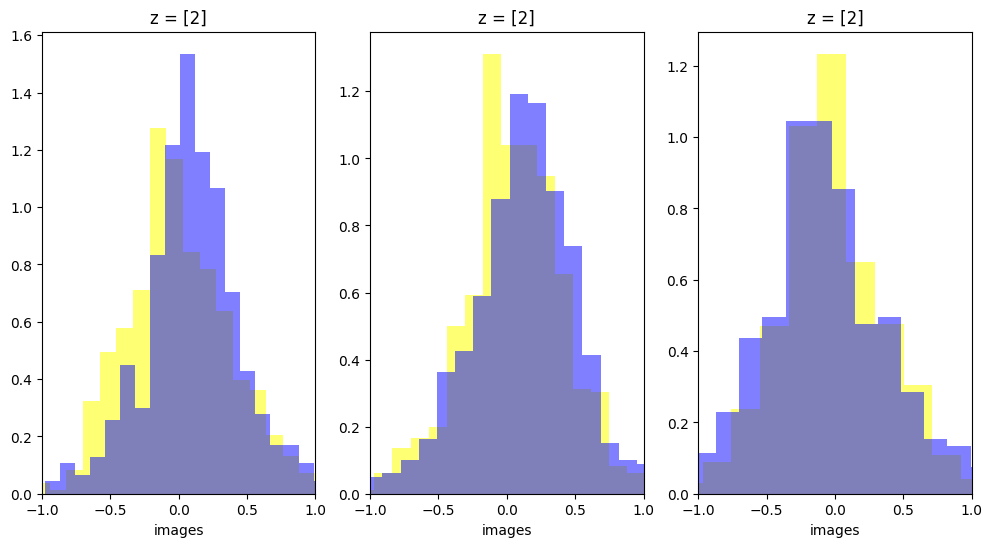

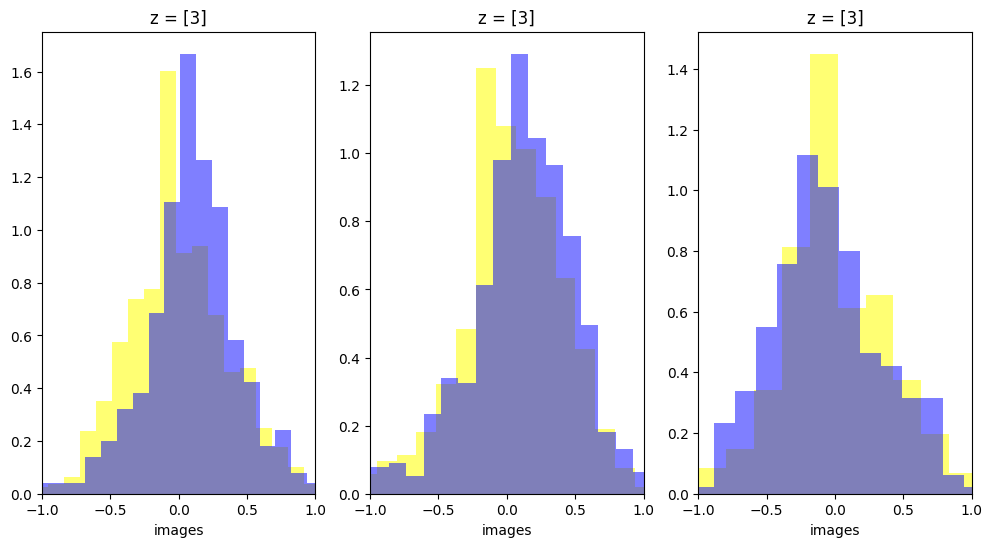

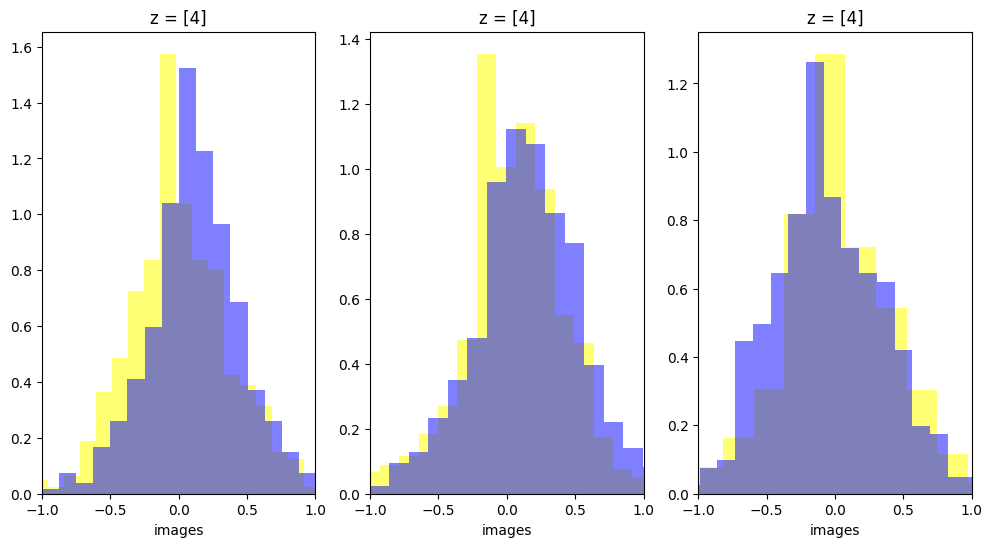

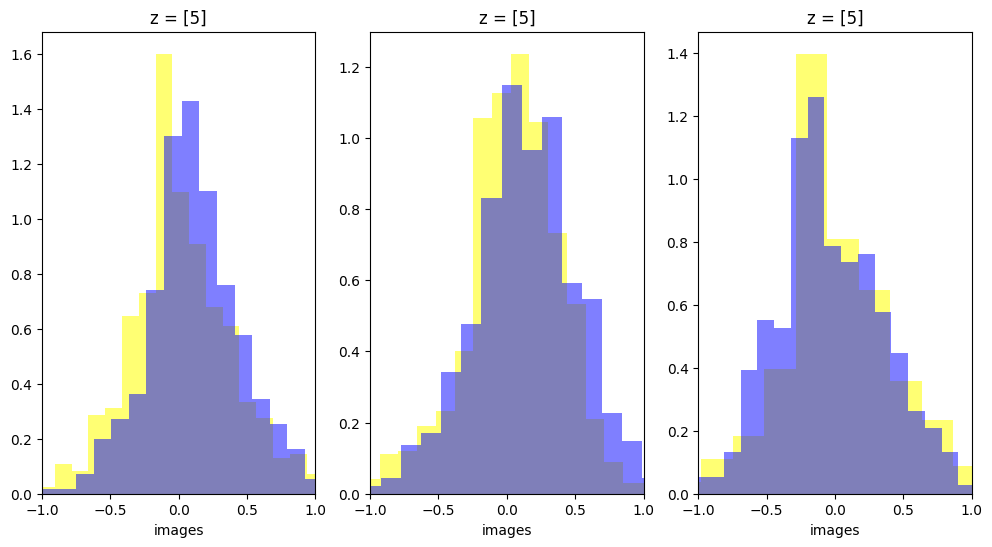

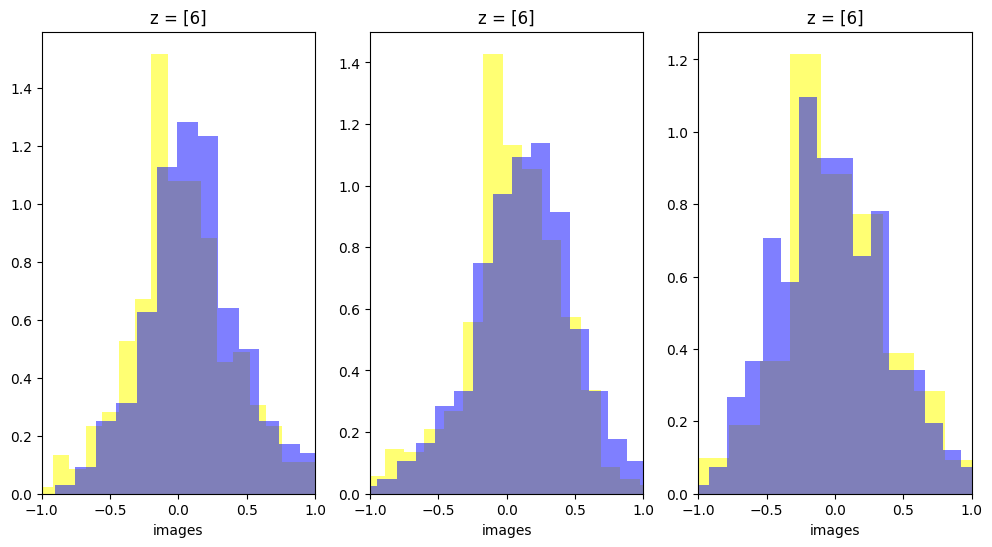

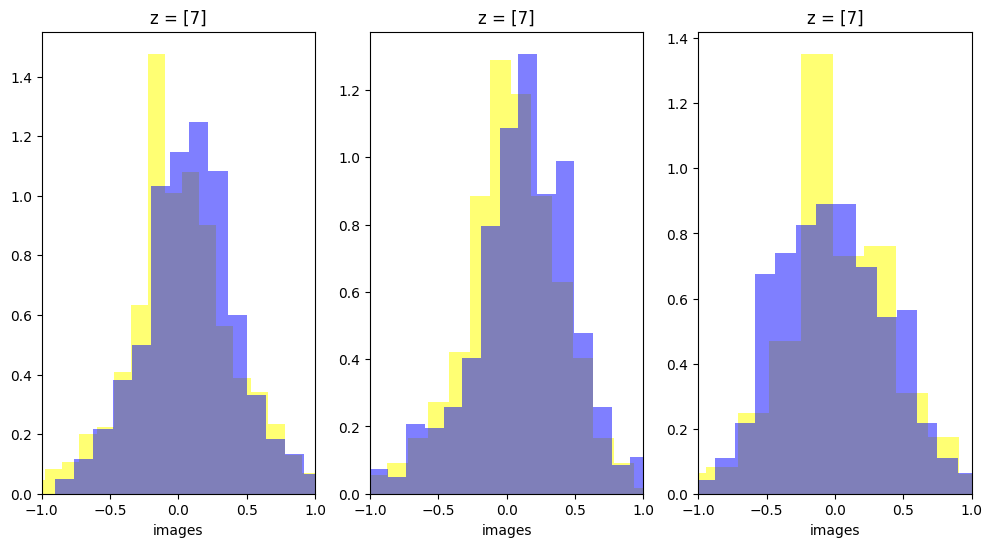

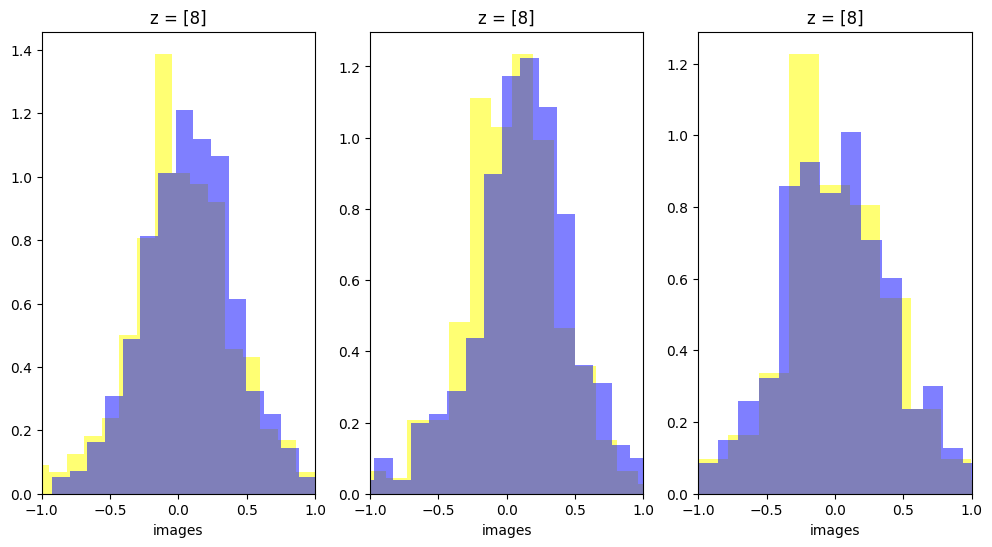

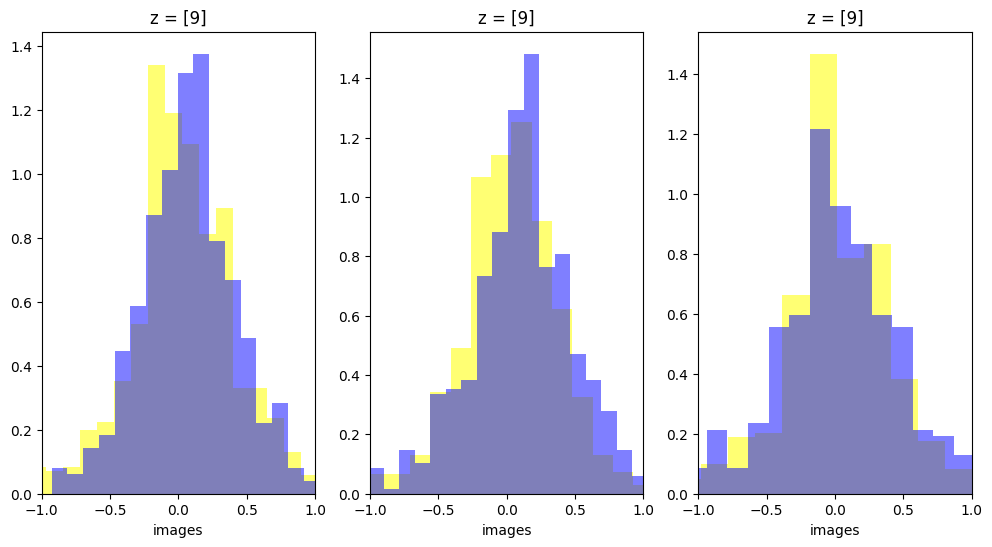

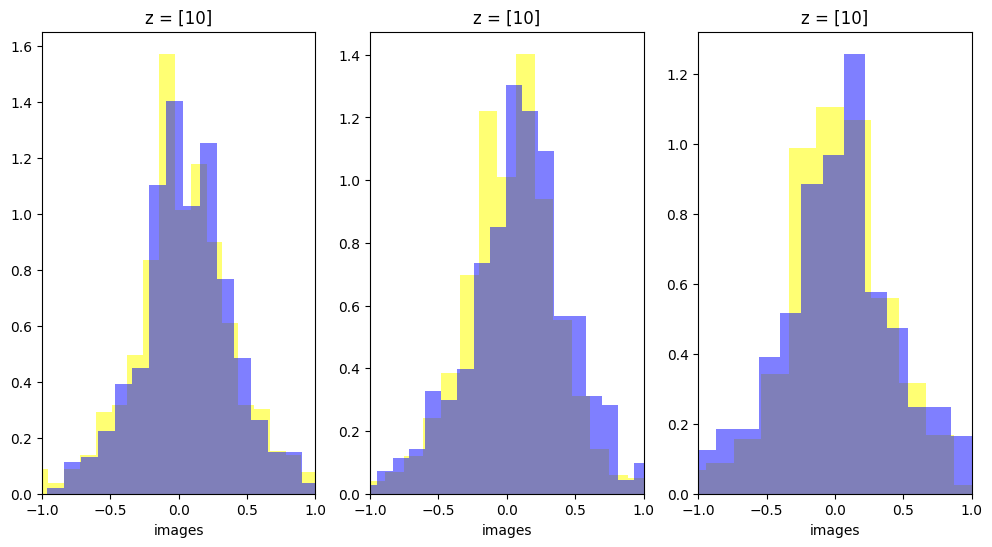

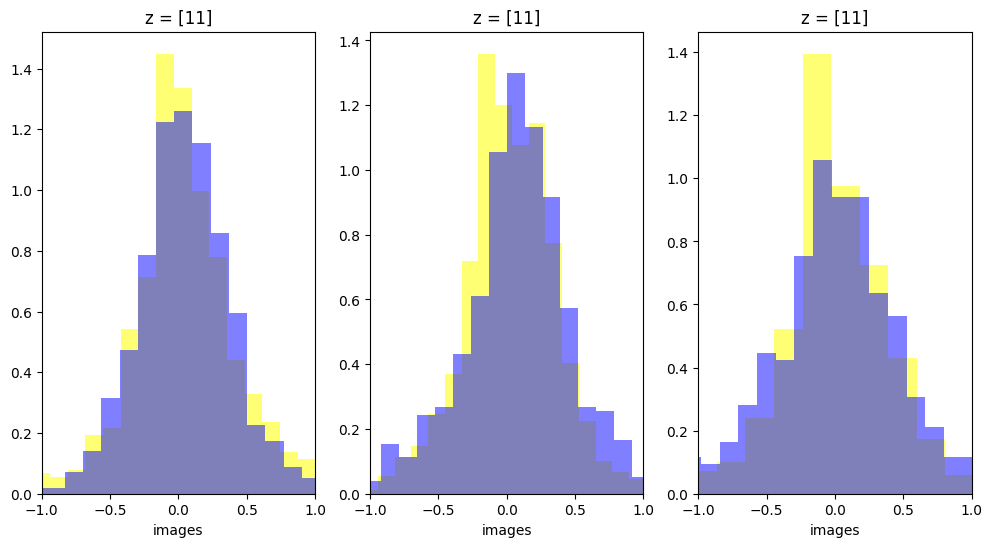

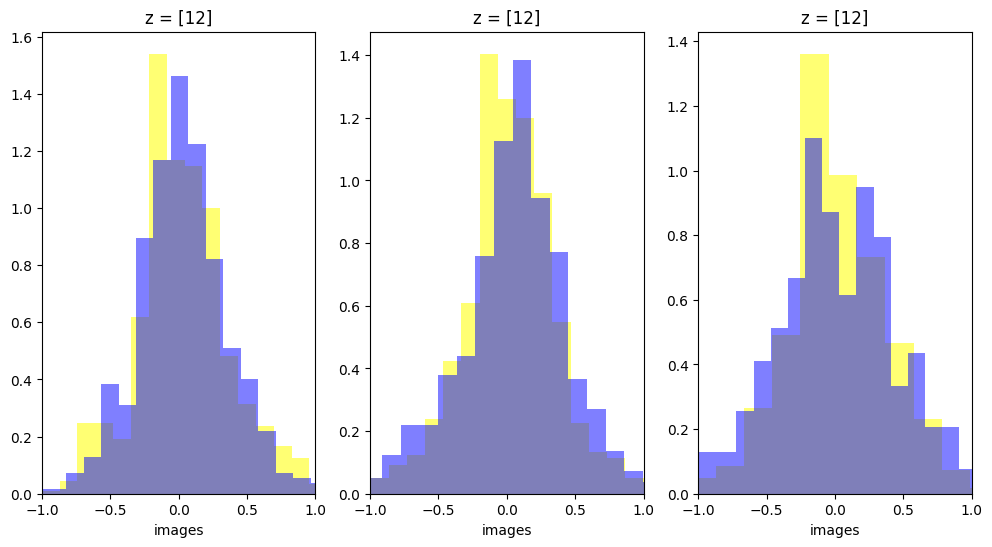

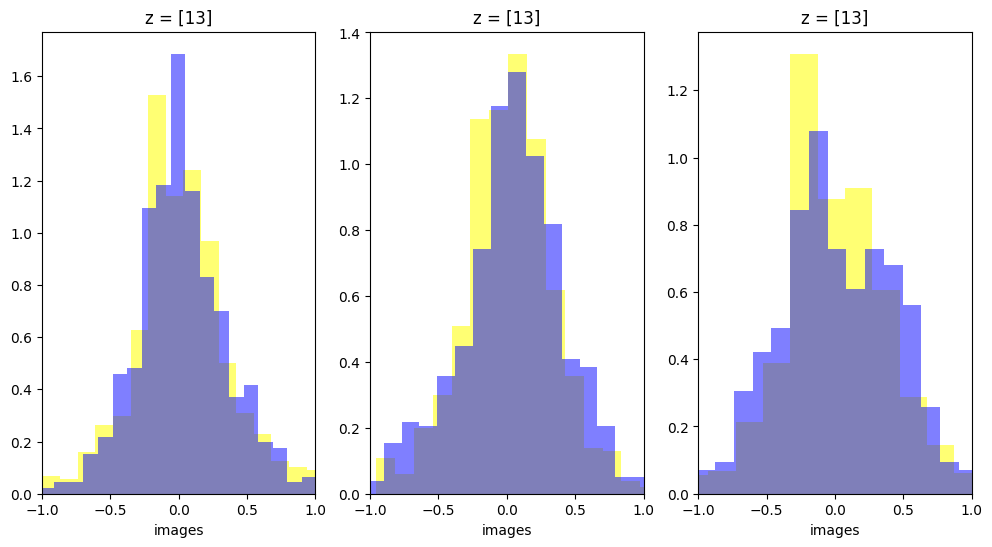

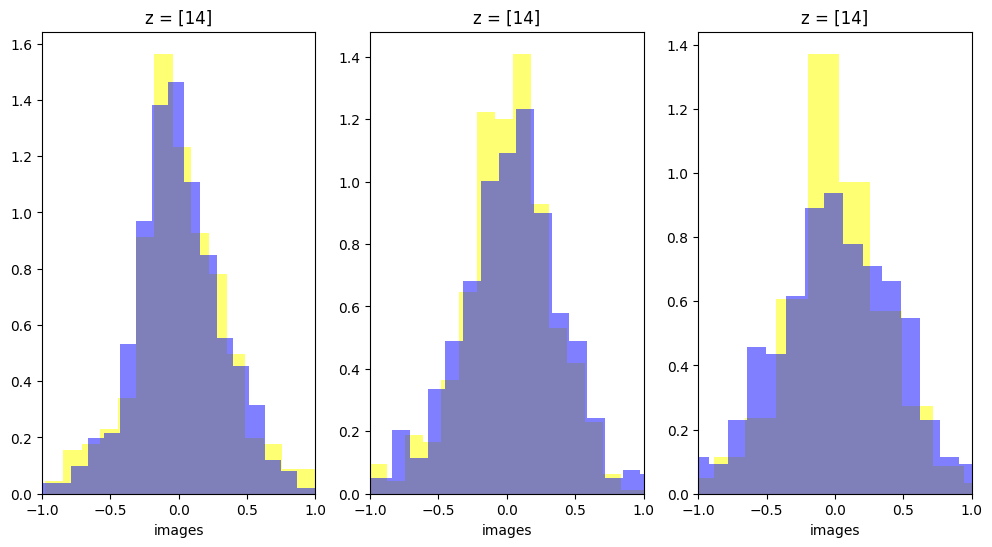

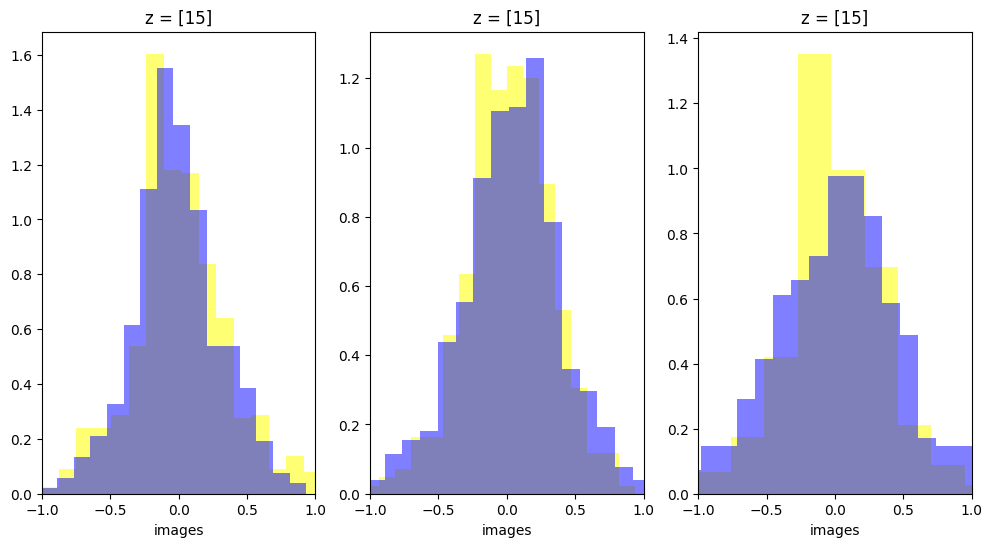

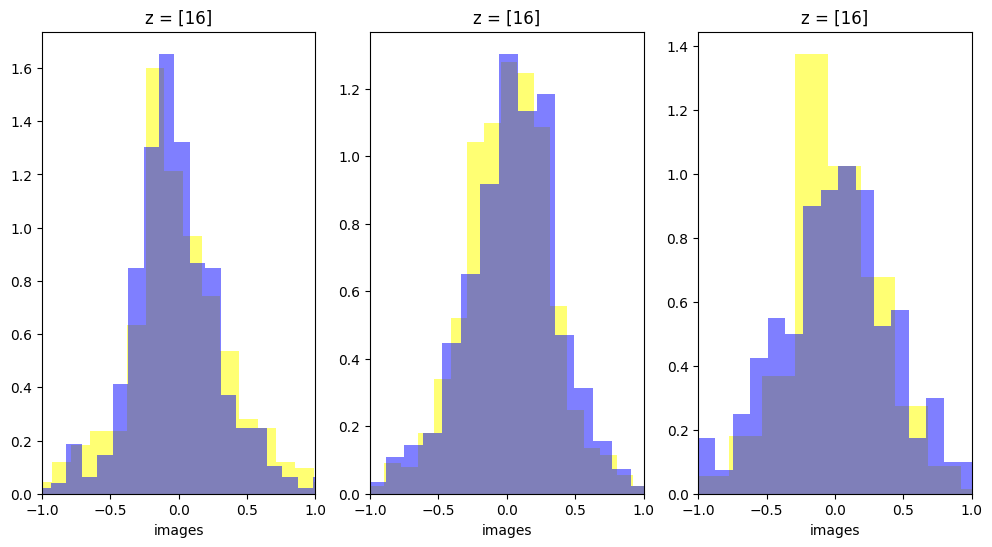

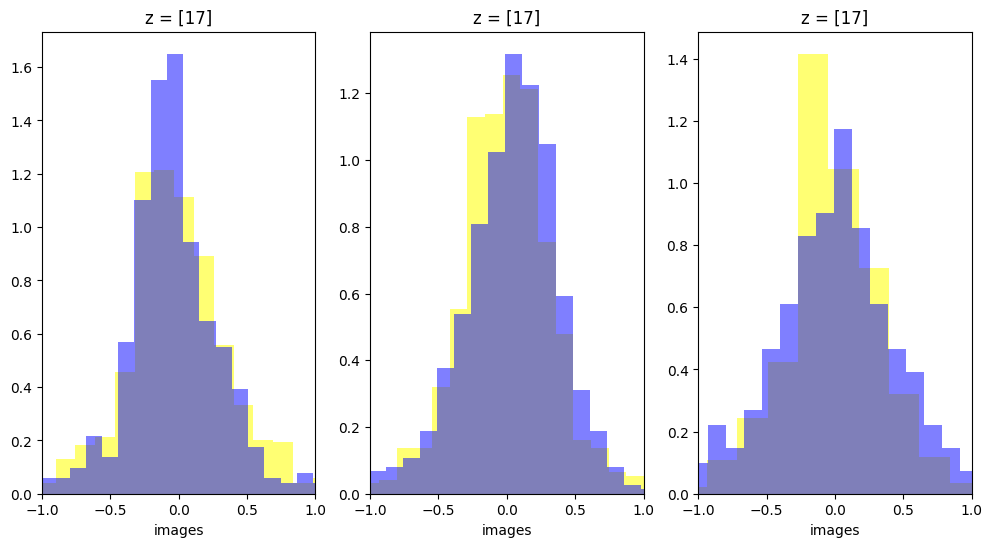

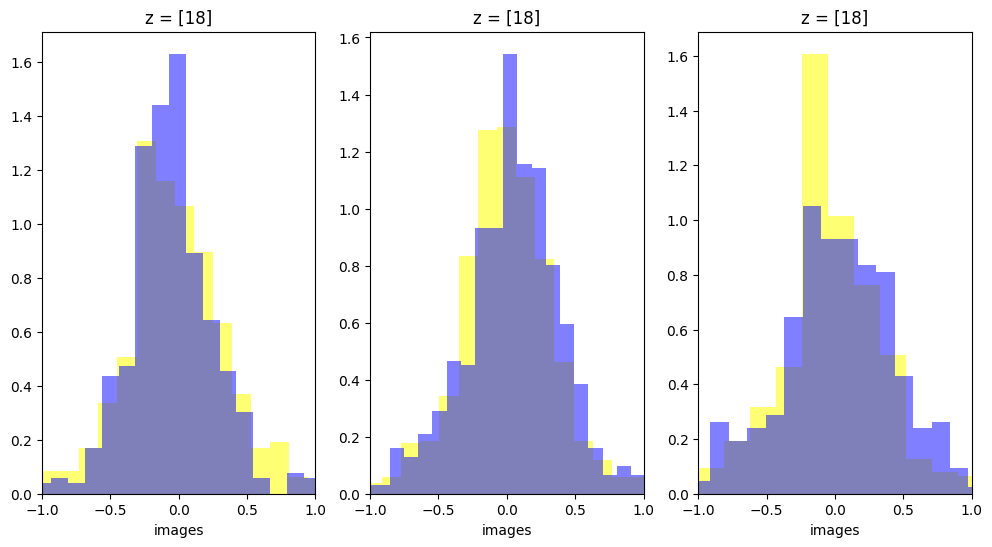

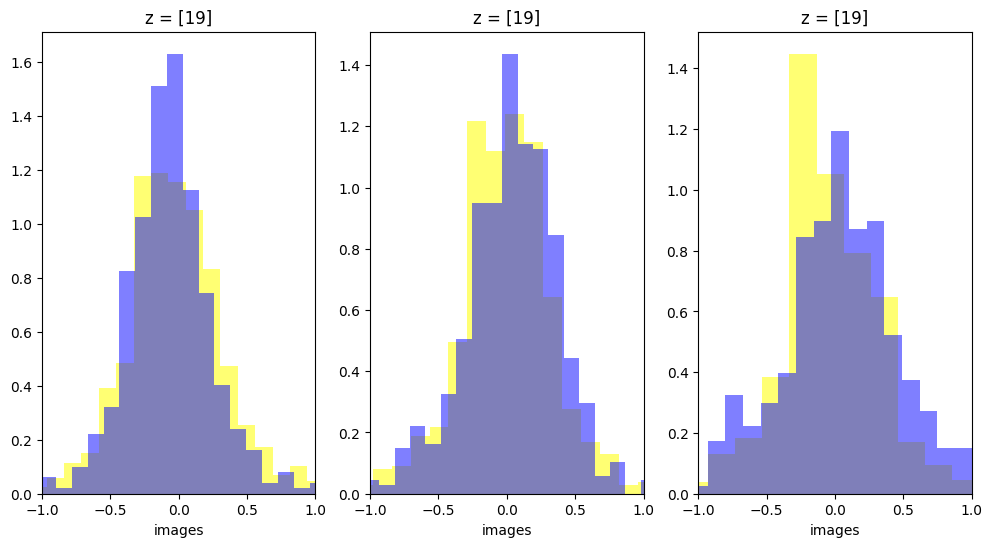

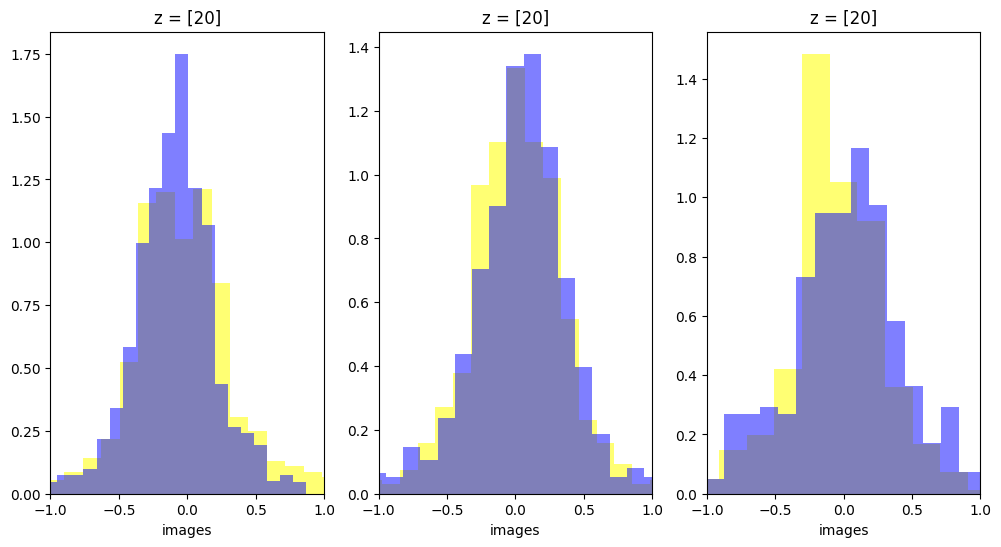

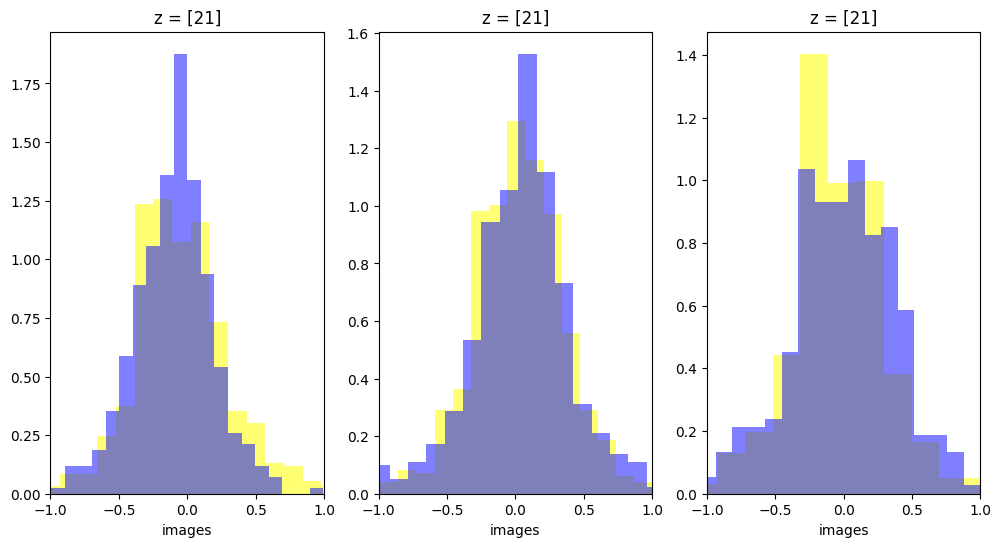

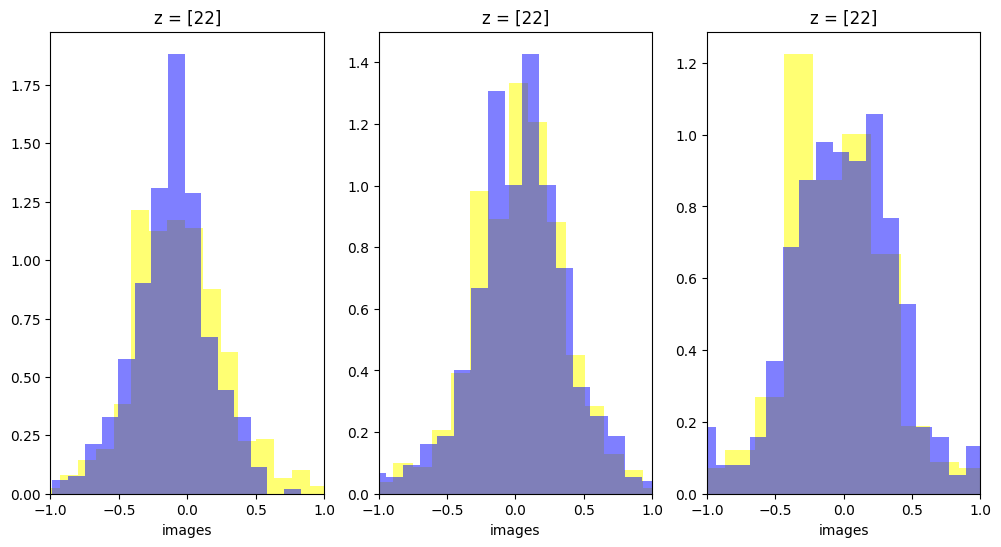

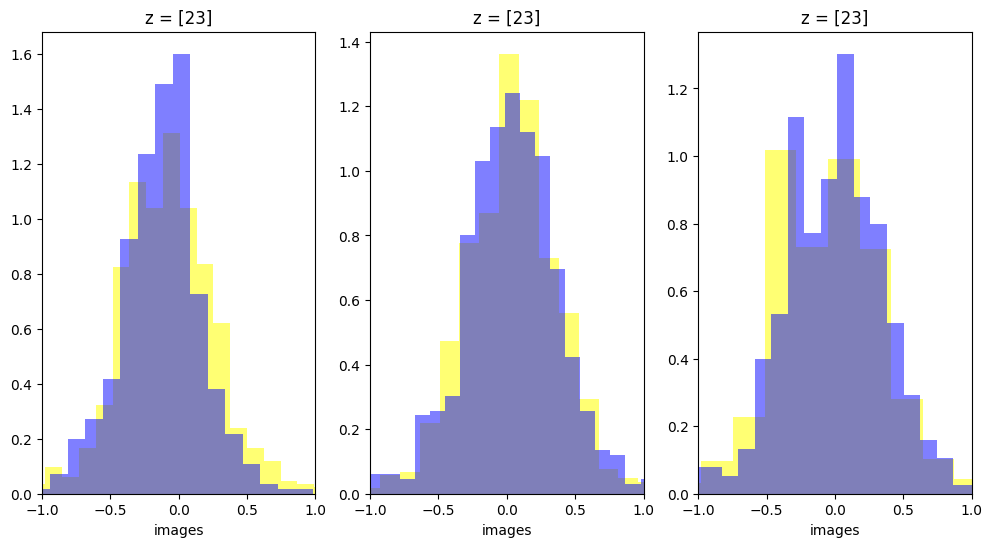

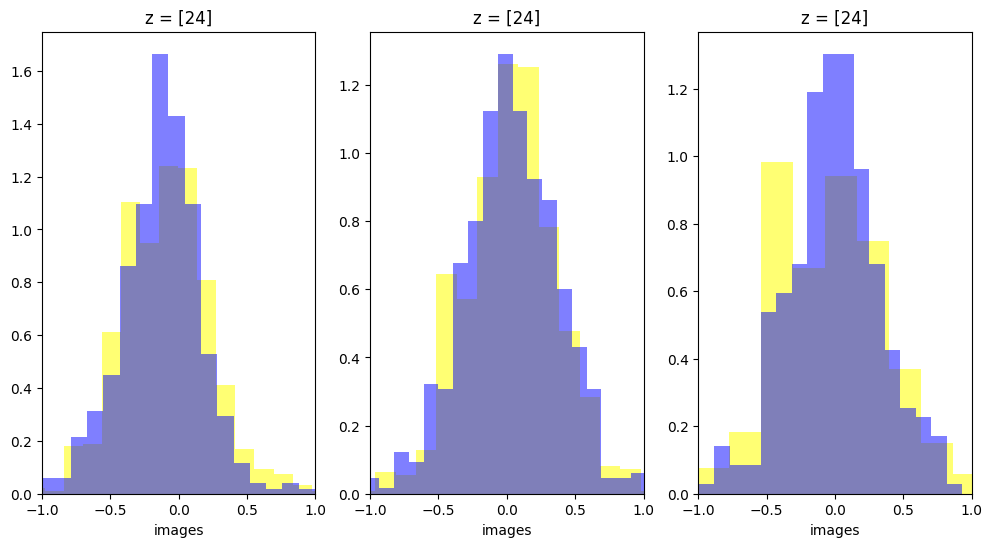

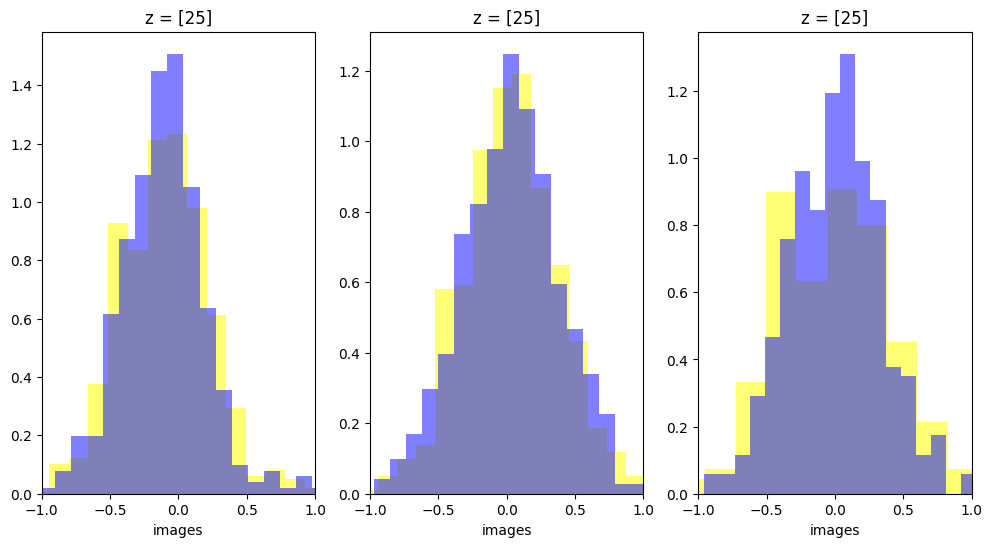

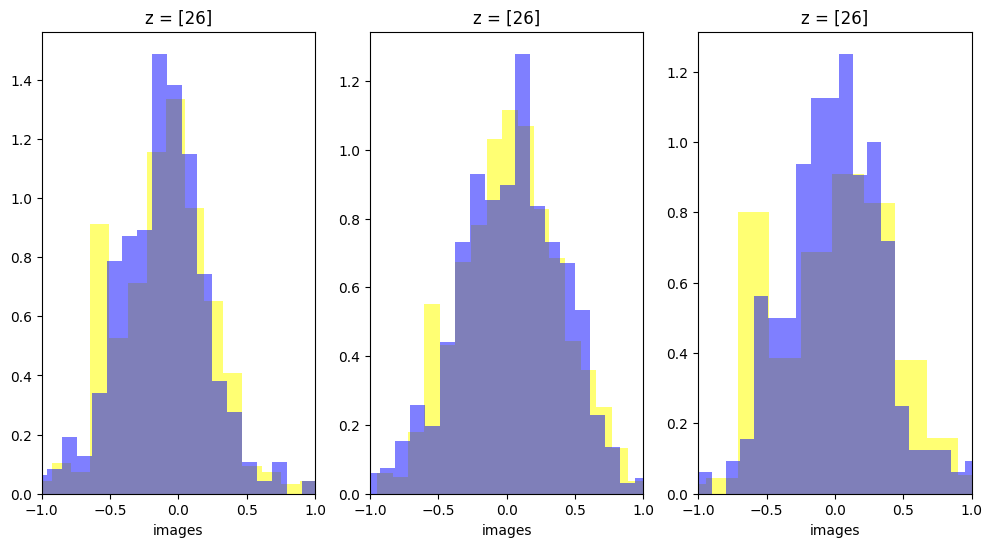

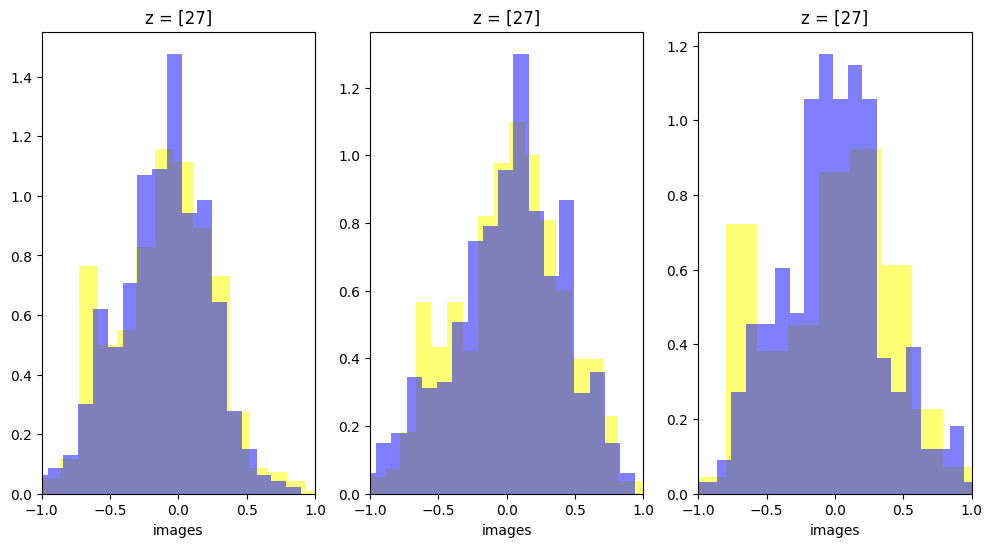

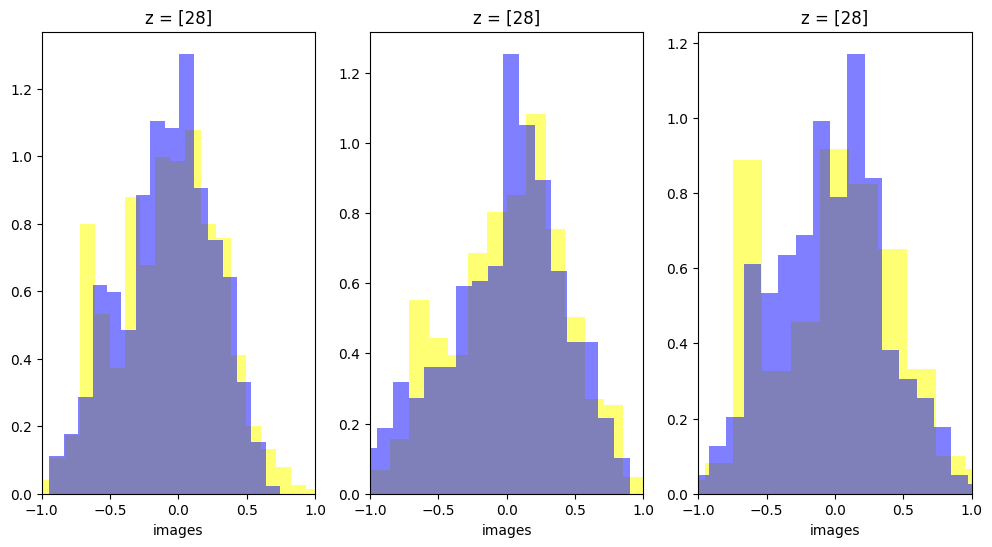

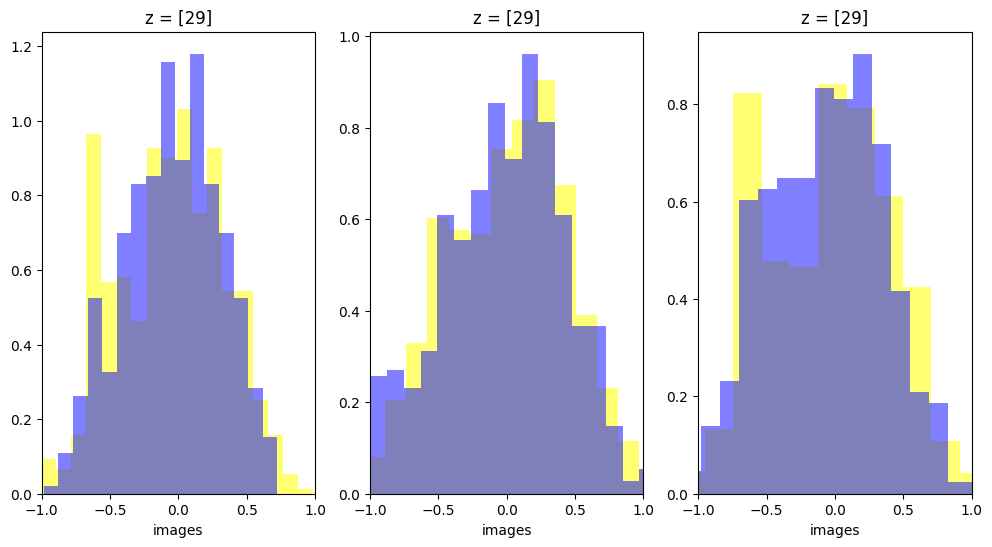

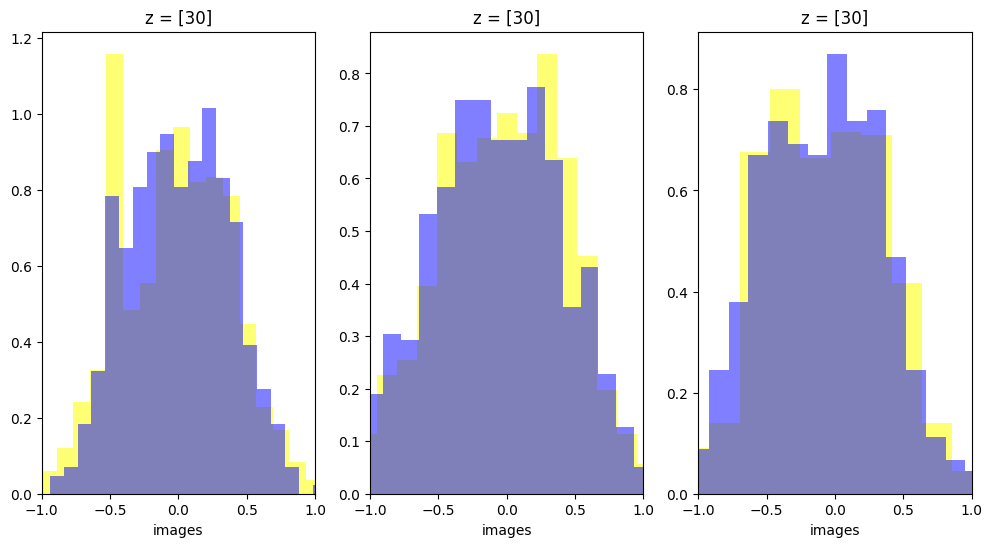

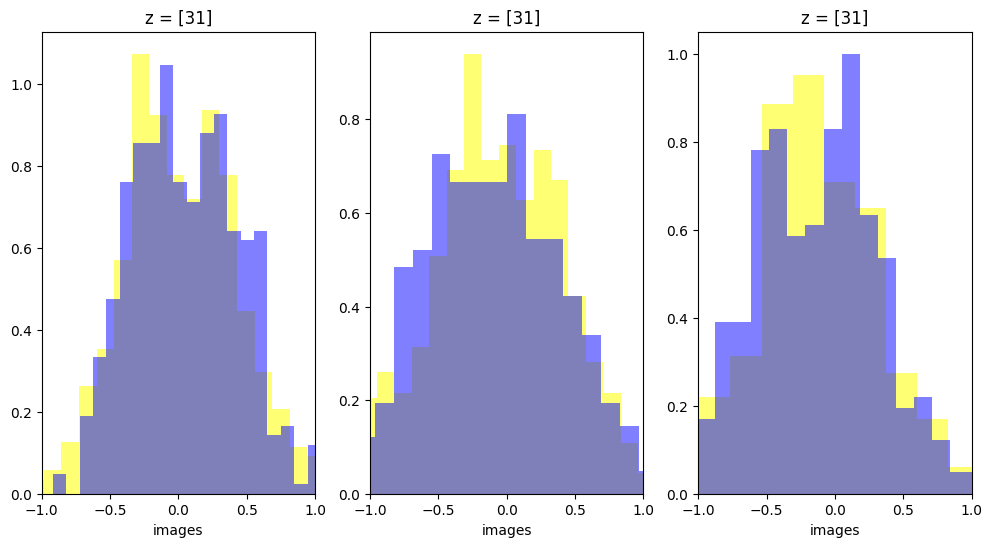

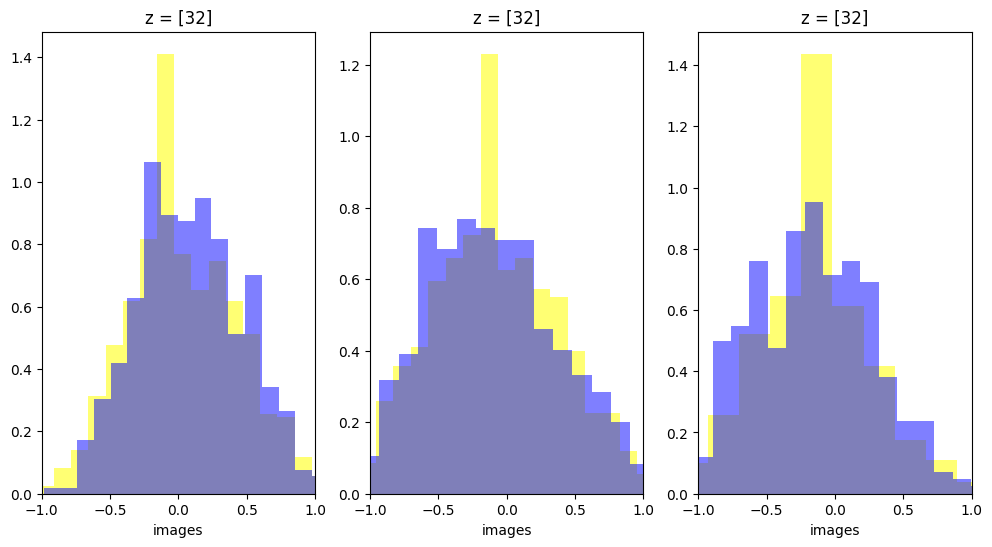

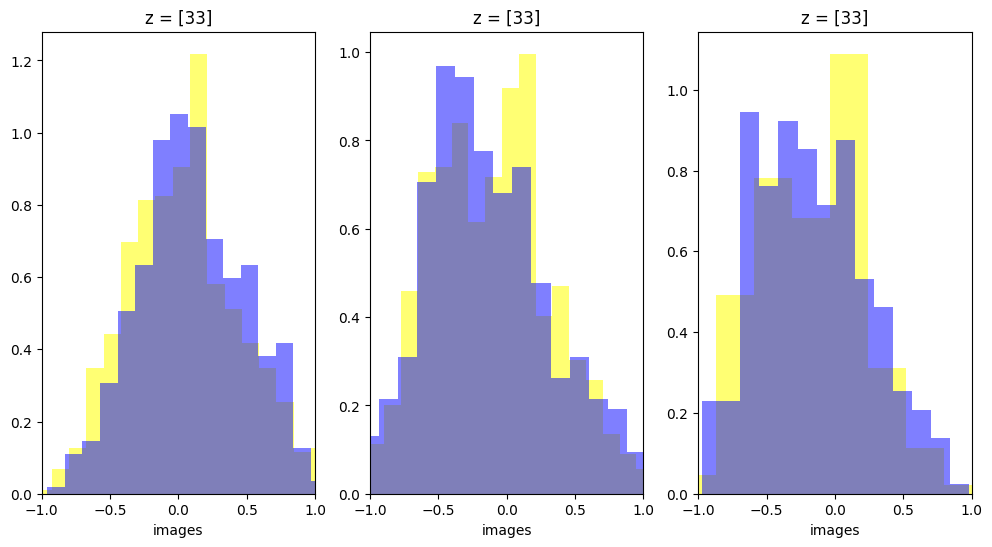

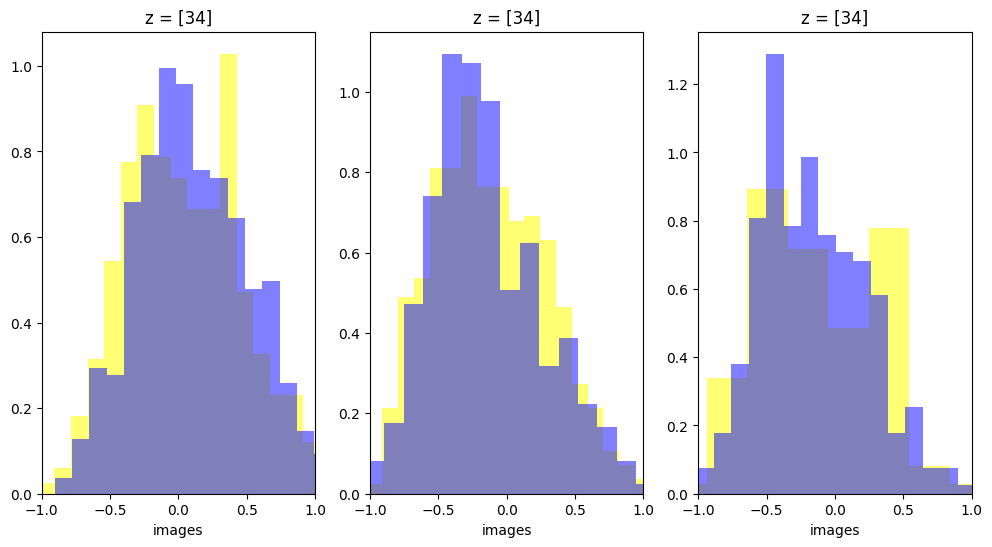

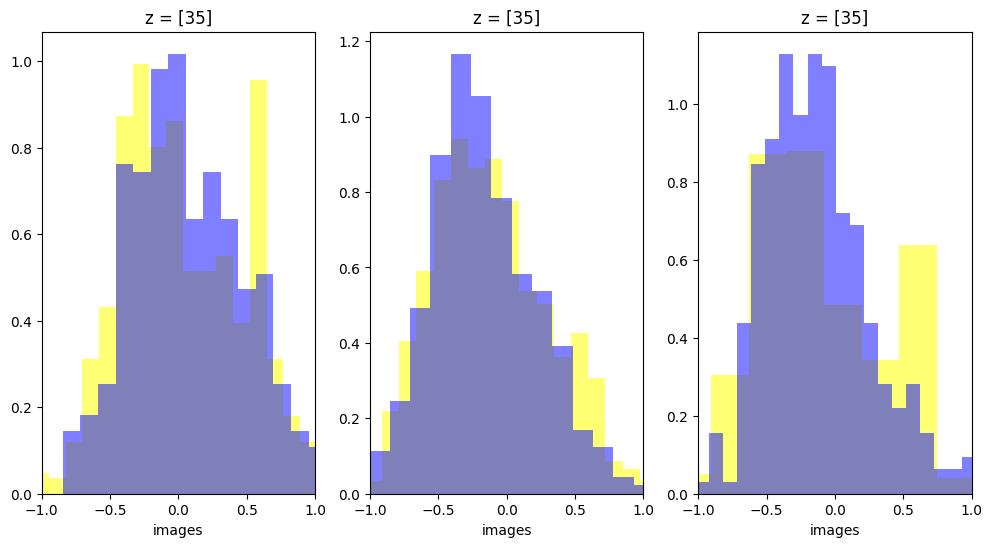

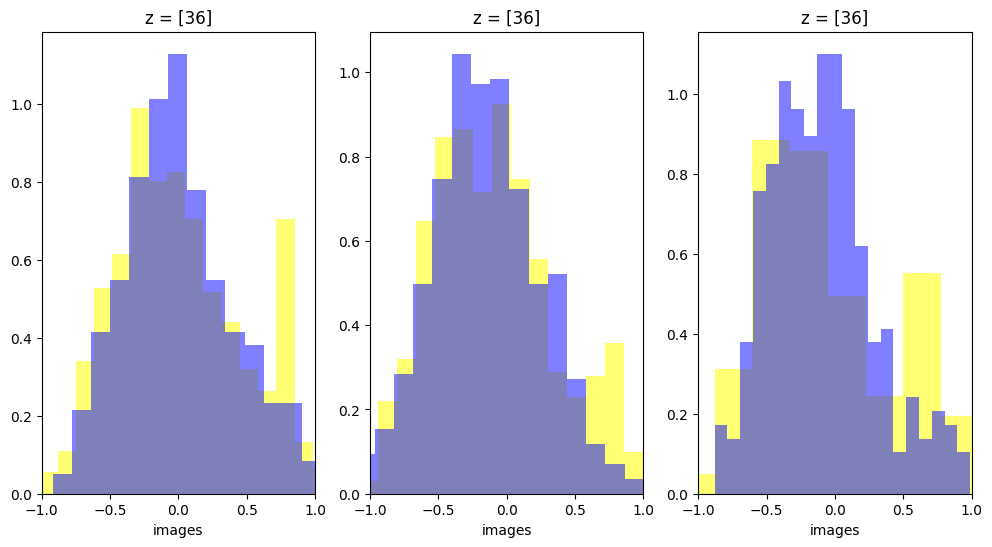

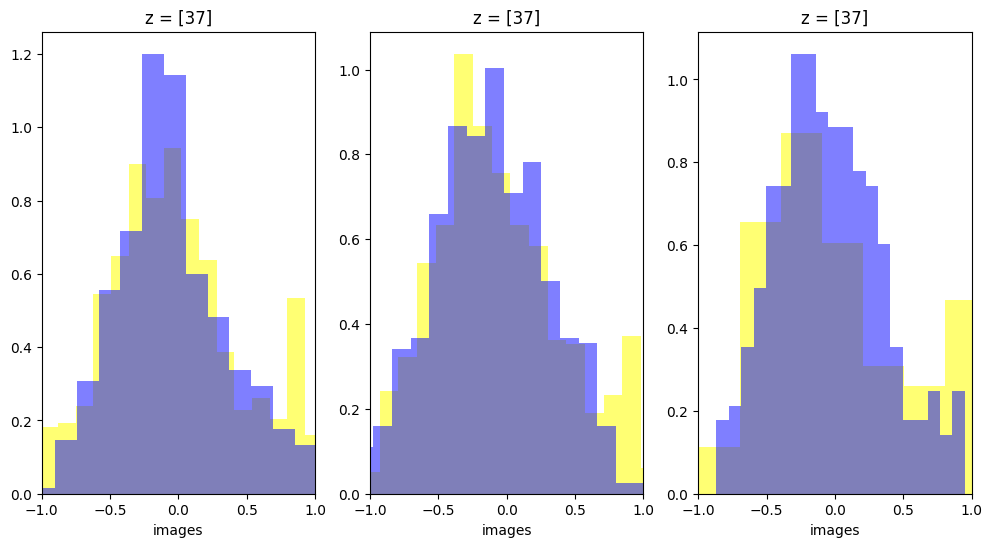

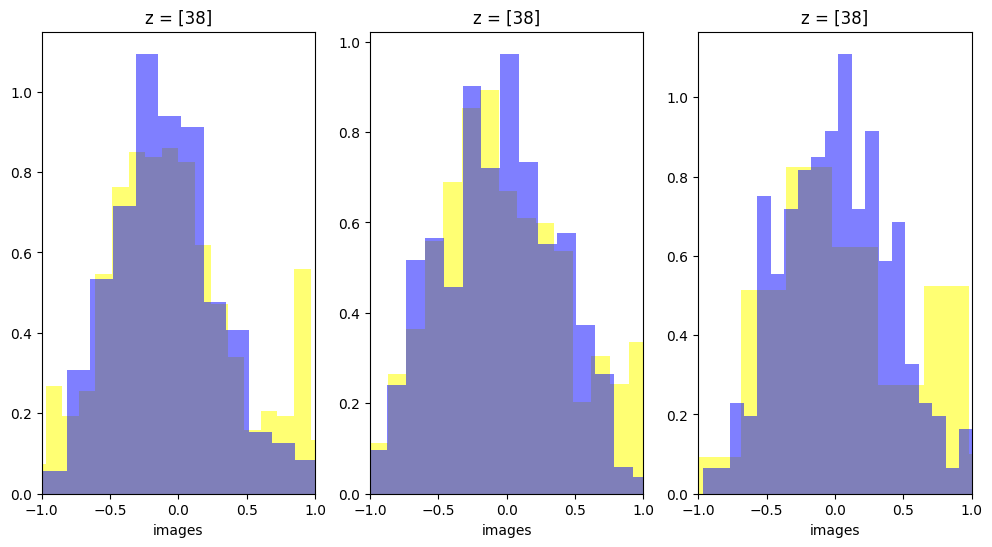

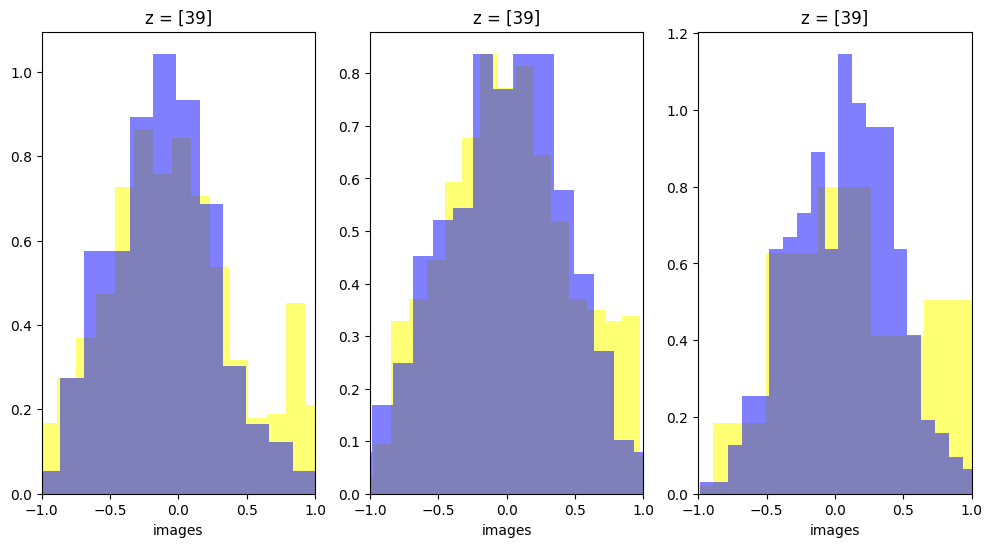

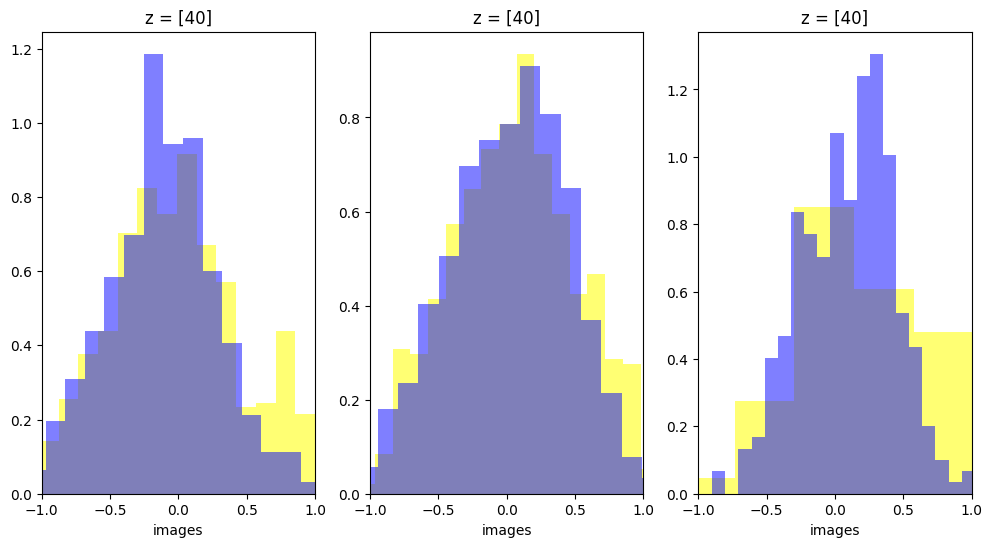

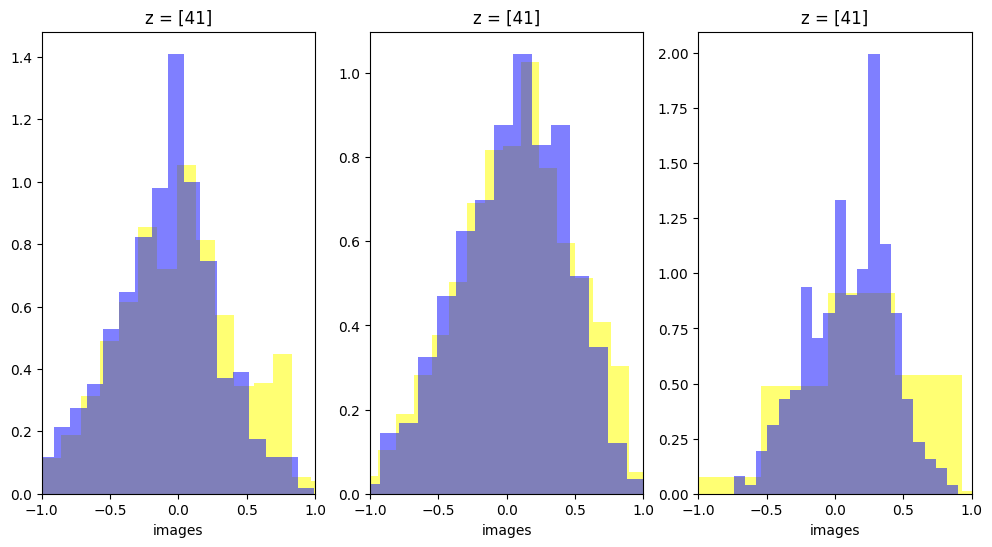

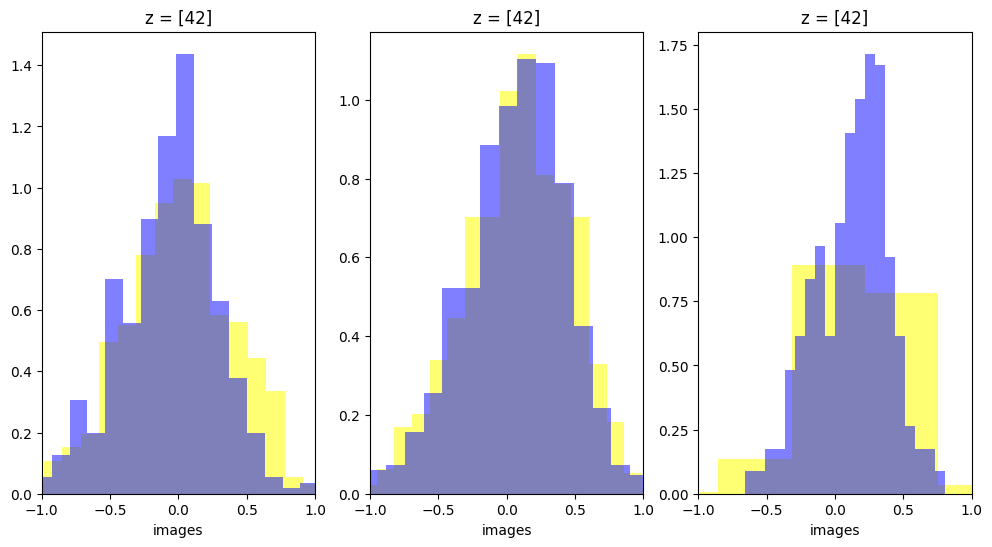

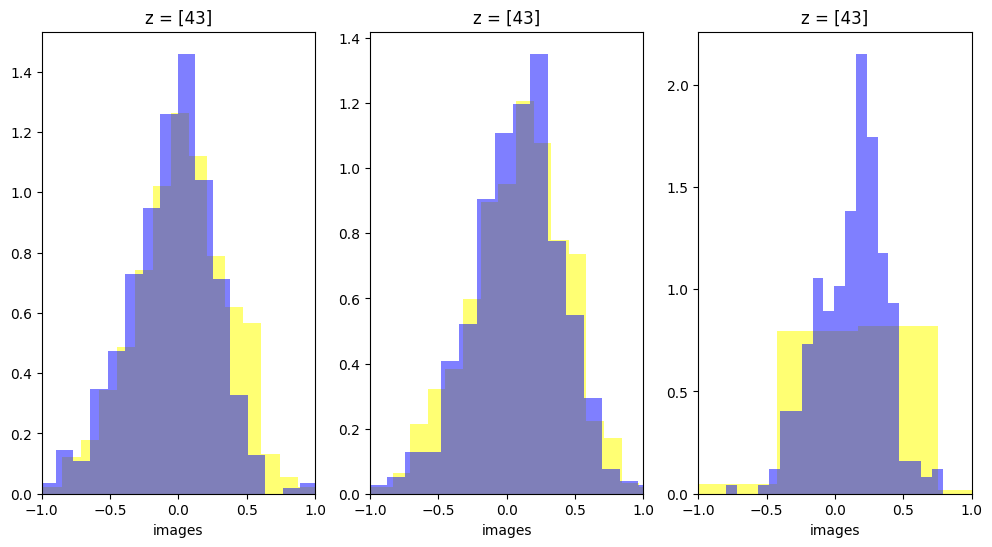

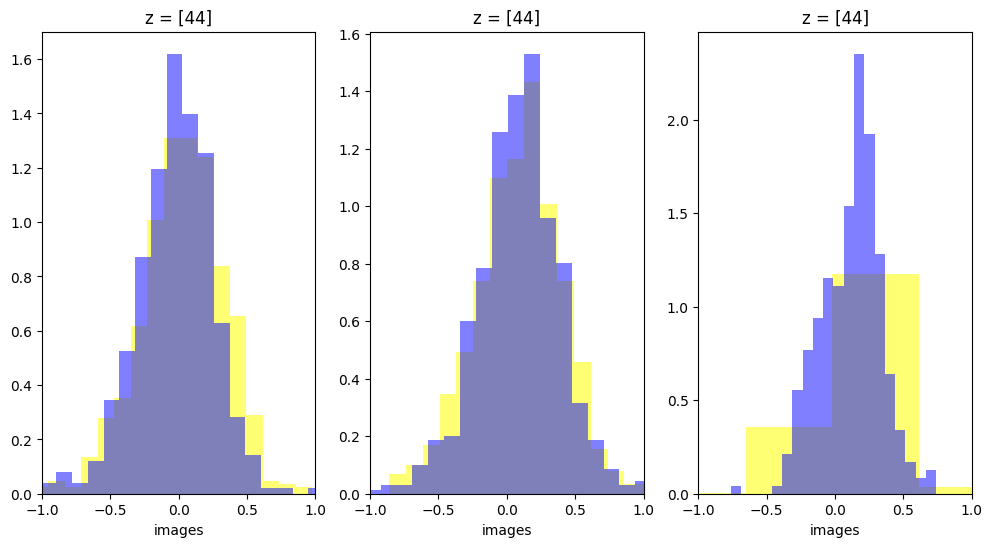

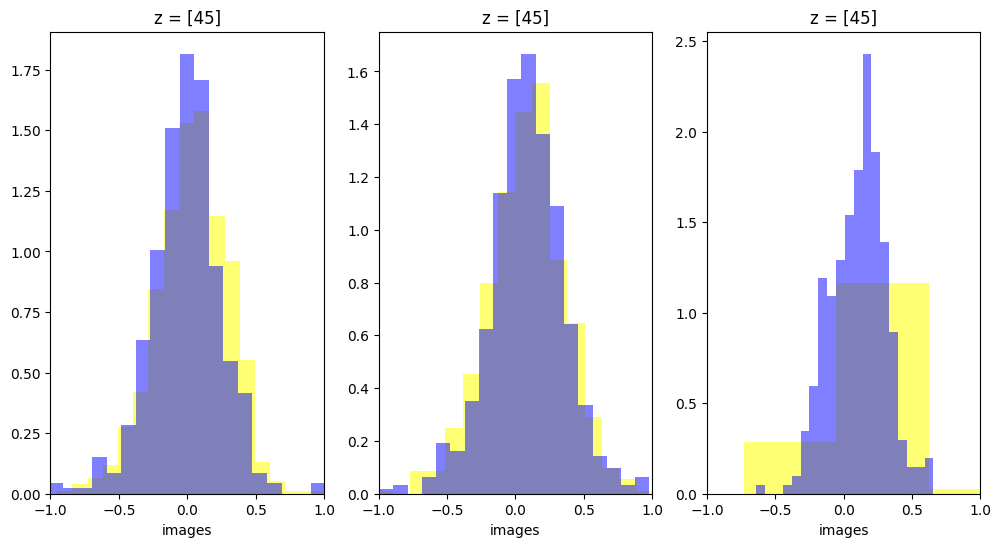

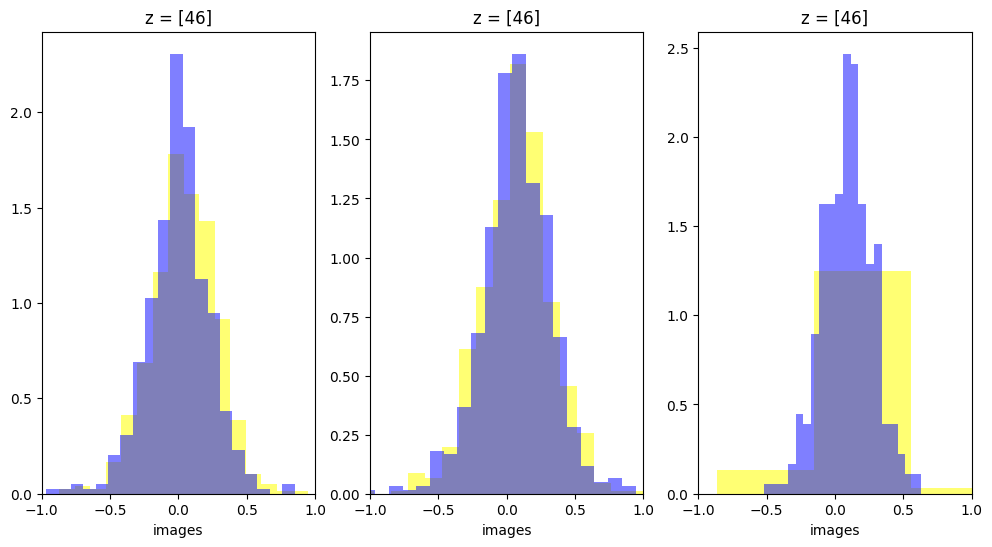

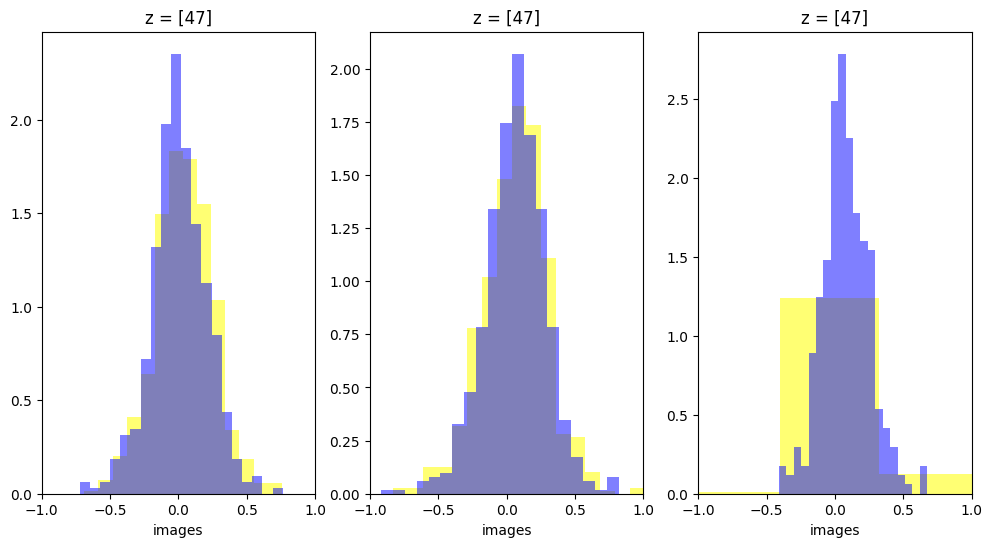

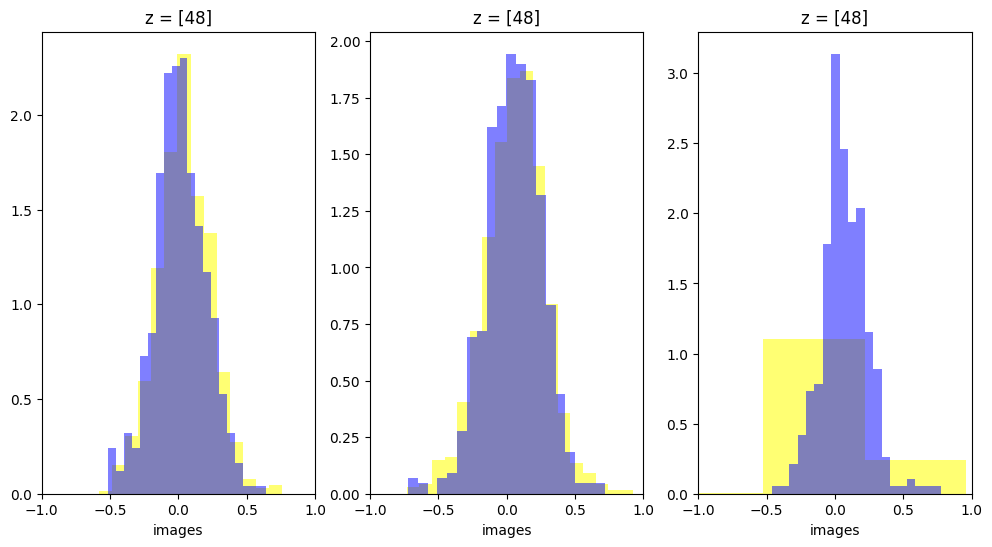

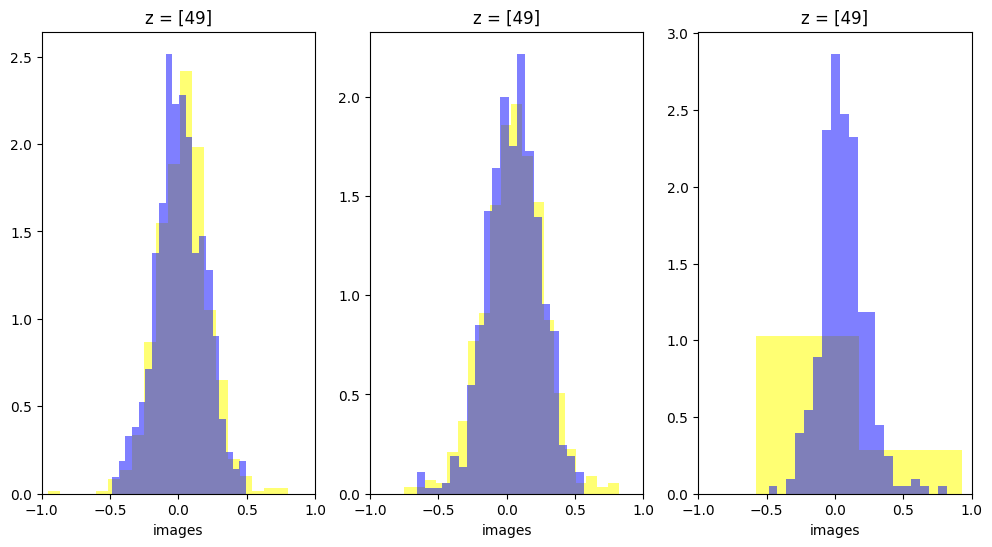

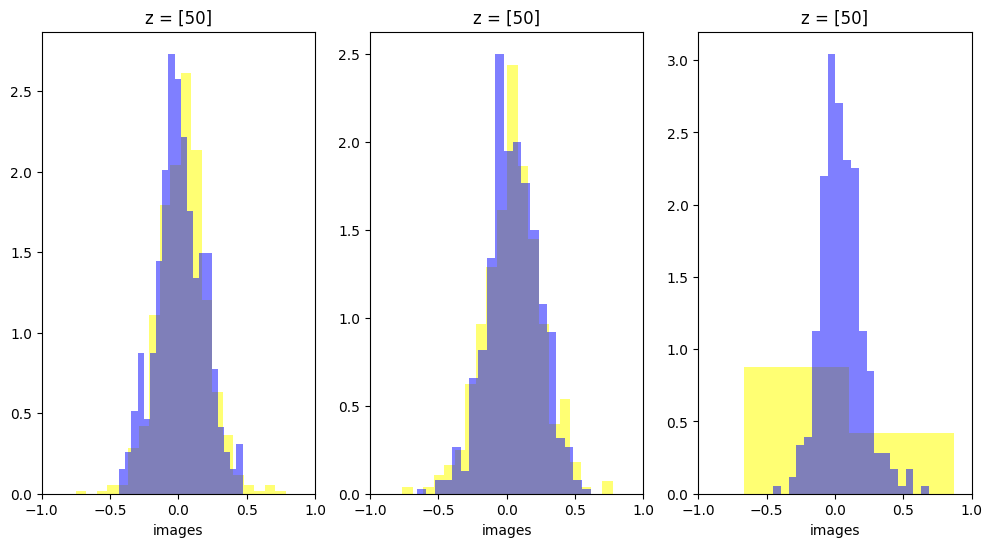

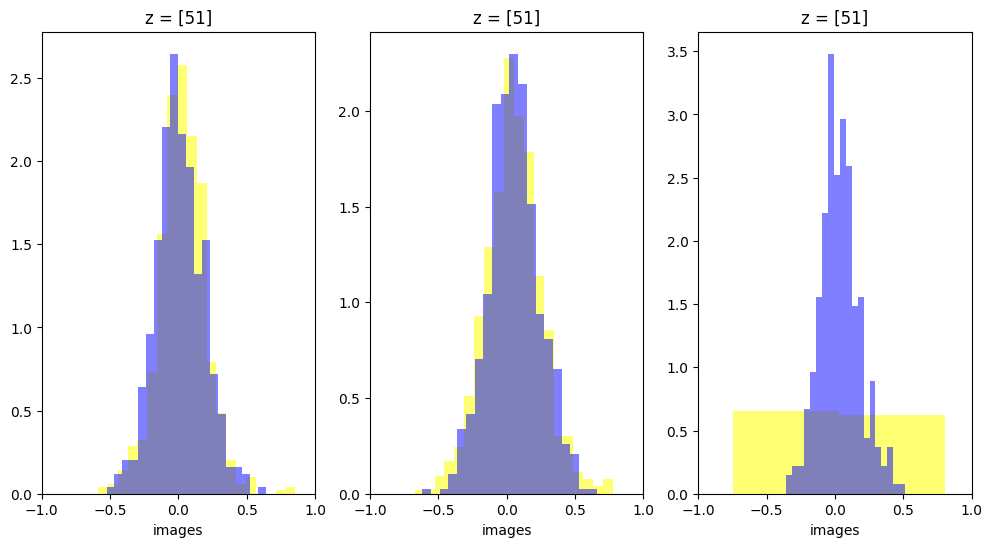

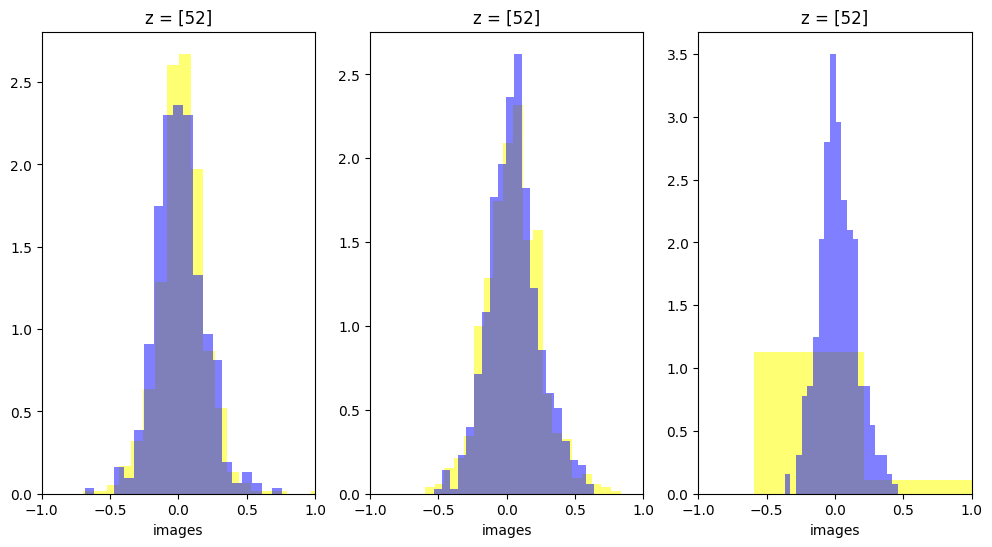

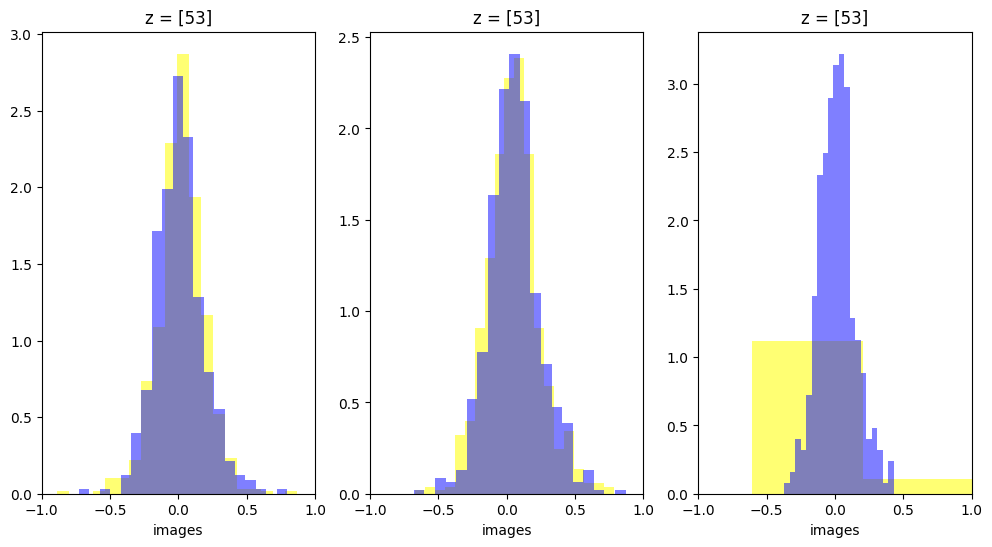

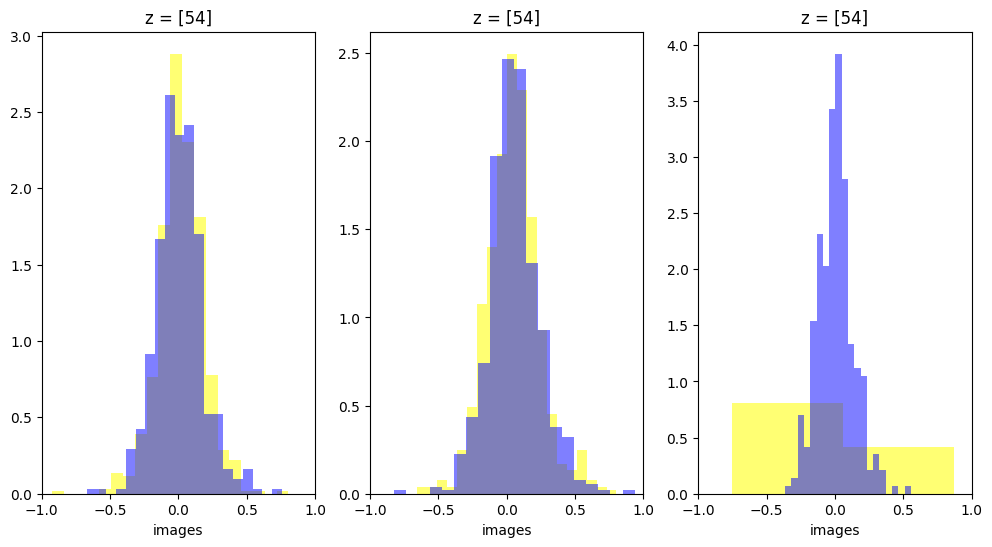

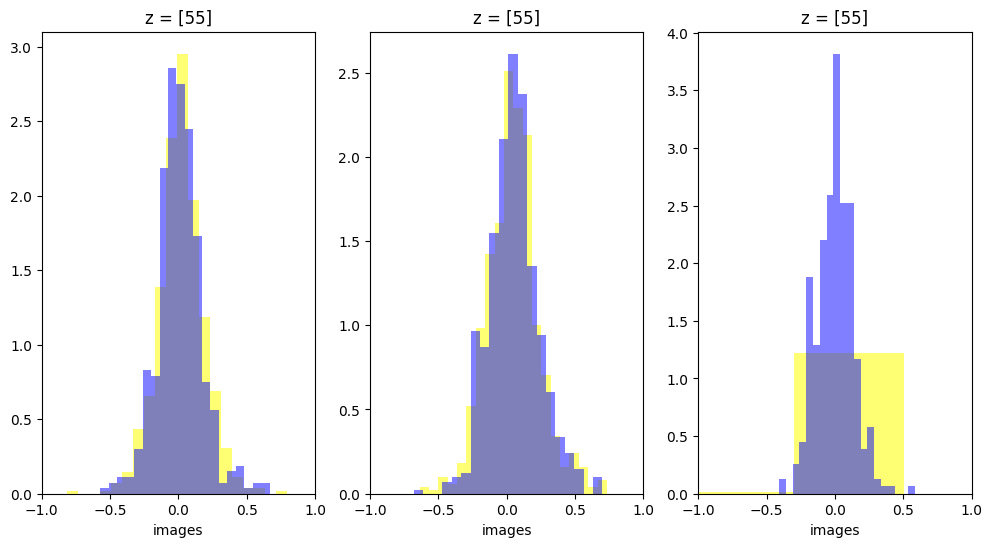

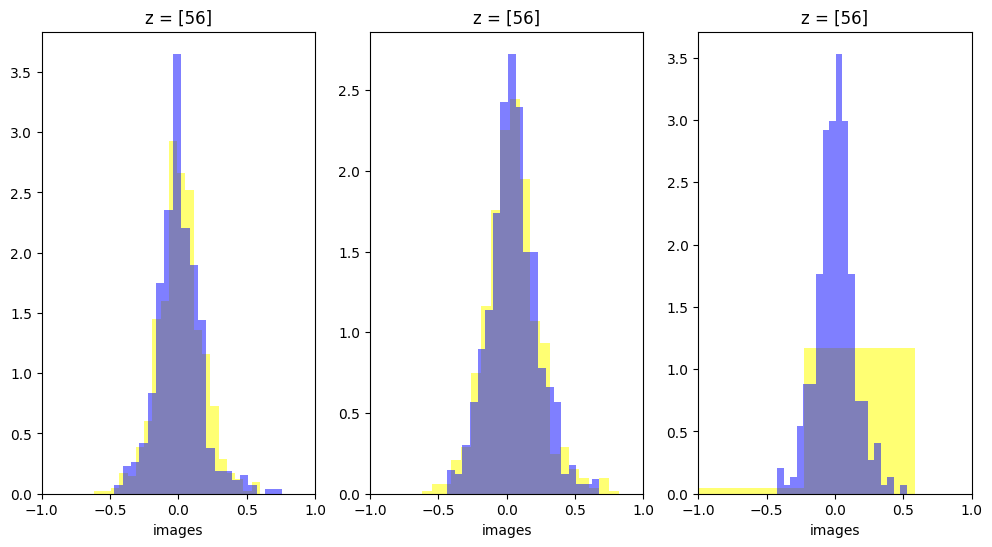

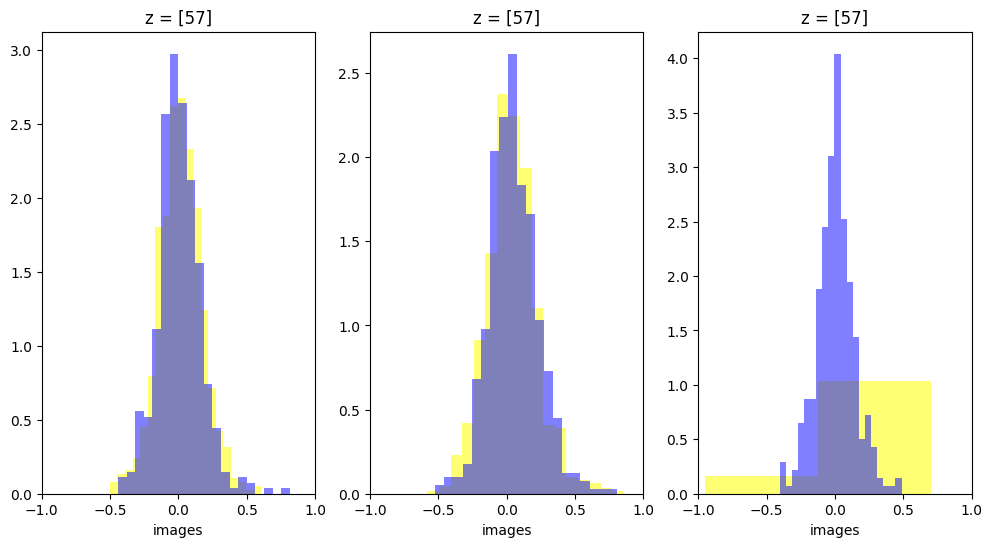

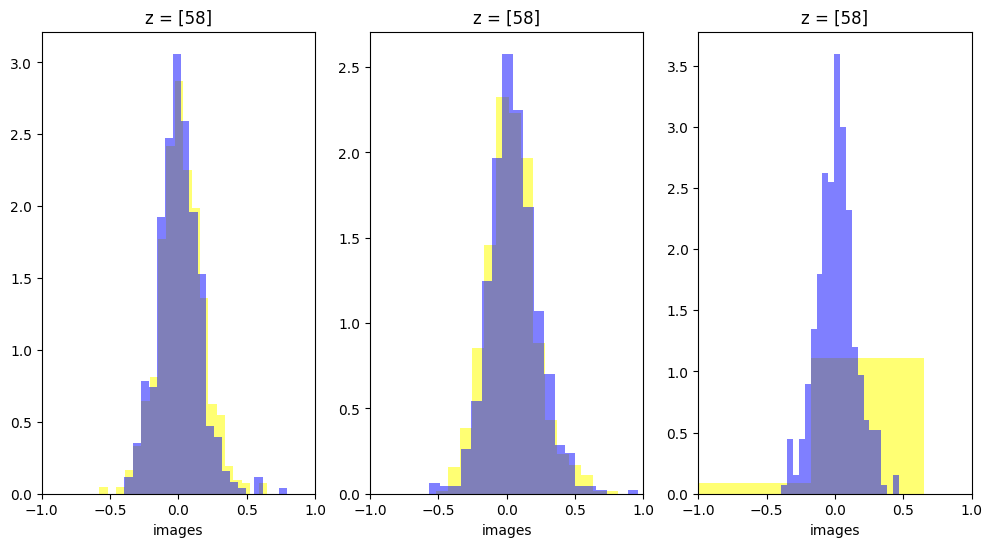

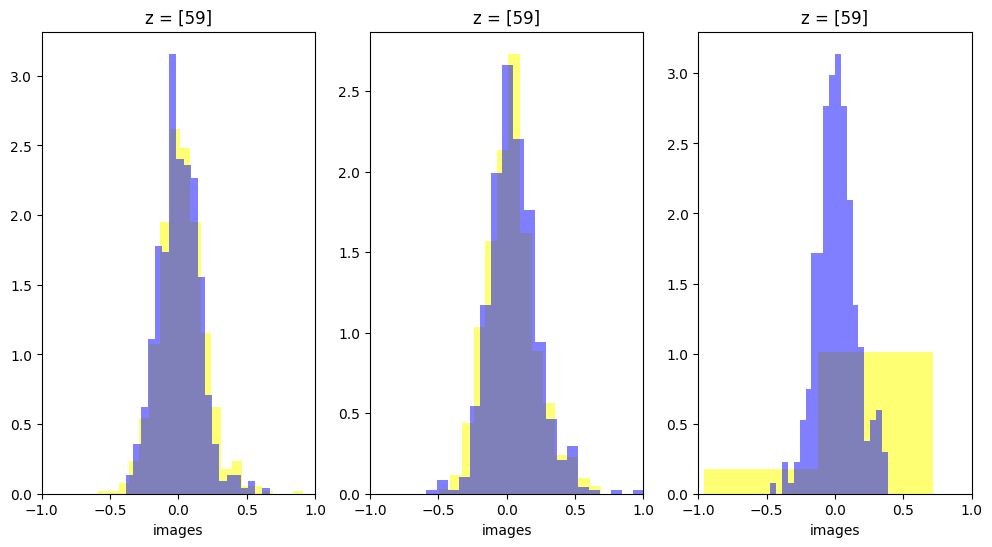

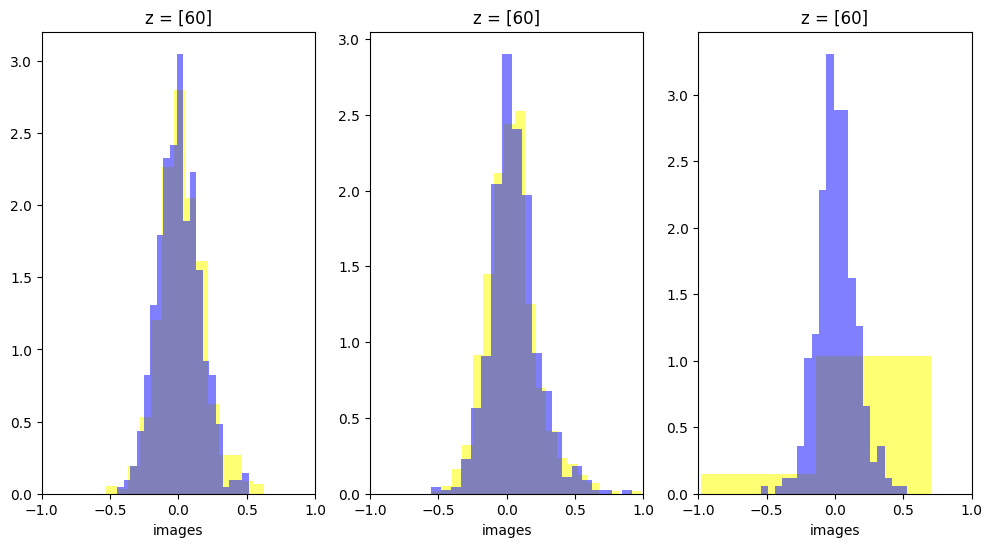

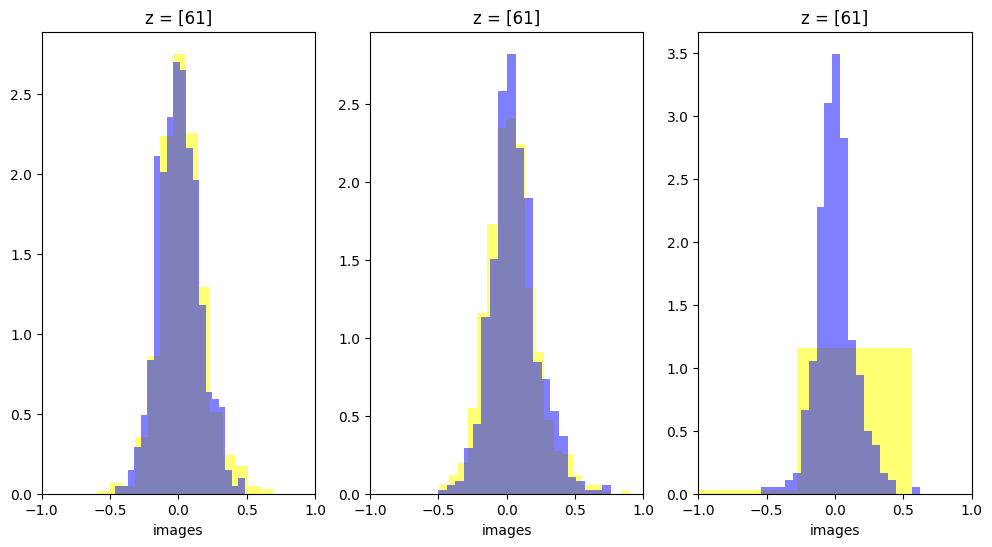

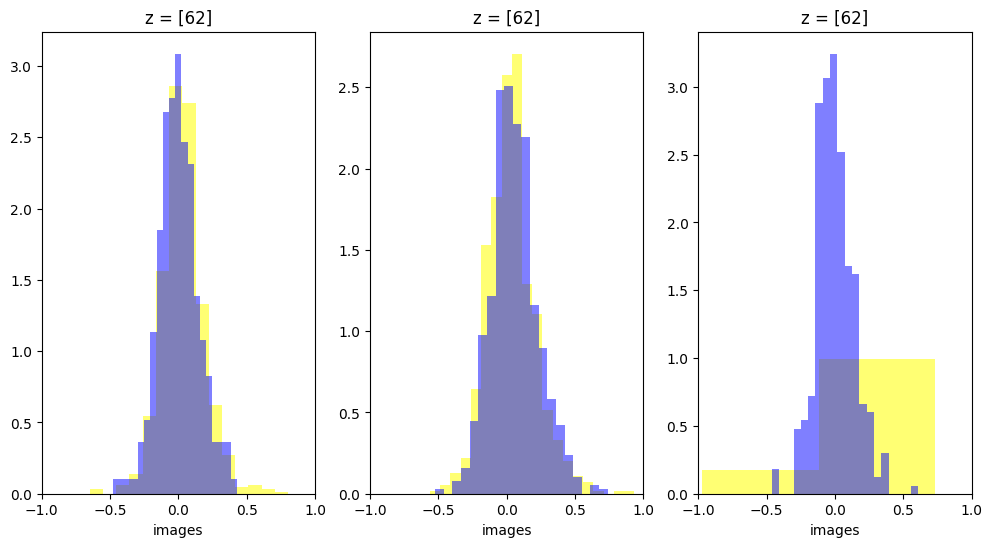

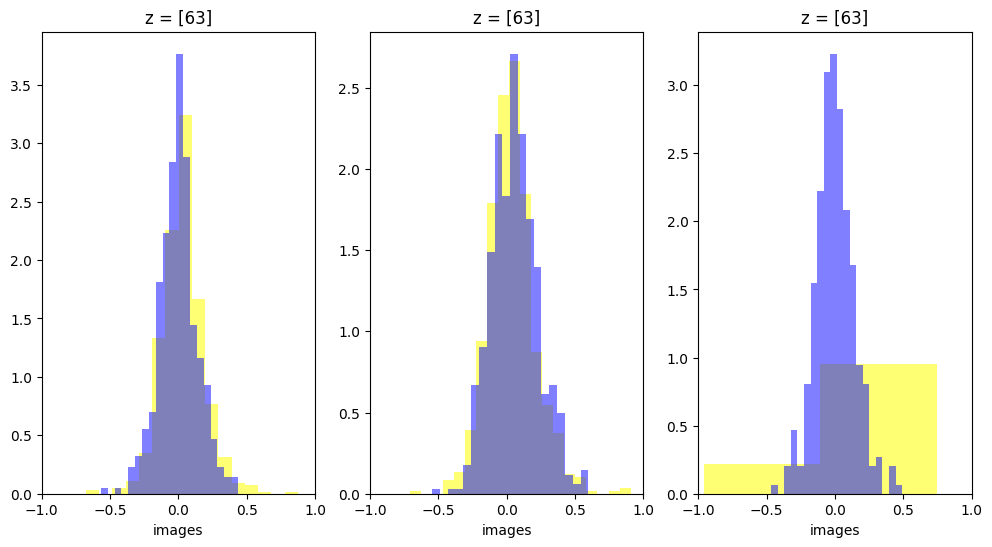

In [147]:
Ngrps = 3
ds_grp = ds_coarse.groupby(ds_coarse.y // (ds_coarse.y[-1] // Ngrps + 1))
list(ds_grp)[0:Ngrps]
for z_sel in range(0, 64):
    fig, axs = plt.subplots(1, len(ds_grp), figsize=(12, 6))
    for (g, d), ax in zip(ds_grp, axs):
        dsn = d.isel(z=slice(z_sel, z_sel + 1))
        dsn.images.where(~d.labels & d.mask).plot.hist(ax=ax, bins=20, color='yellow', alpha=.55, density=True)
        dsn.images.where(d.labels & d.mask).plot.hist(ax=ax, bins=20, color='blue', alpha=0.5, density=True)
        ax.set_xlim(-1, 1)
    plt.show()

In [5]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler

# Generate synthetic data for two irregular 2D distributions
np.random.seed(42)

# Gaussian mixture model parameters for two populations
means1 = np.array([[0, 0], [3, 3]])
covs1 = np.array([[[1, 0.5], [0.5, 1]], [[1, -0.5], [-0.5, 1]]])
weights1 = np.array([0.6, 0.4])

means2 = np.array([[-3, -3], [-6, -6]])
covs2 = np.array([[[1, 0.5], [0.5, 1]], [[1, -0.5], [-0.5, 1]]])
weights2 = np.array([0.7, 0.3])

gmm1 = GaussianMixture(n_components=2, means_init=means1, precisions_init=np.linalg.inv(covs1), weights_init=weights1)
gmm1.fit(np.random.randn(1, 2))  # Dummy fit for gmm1
samples1 = gmm1.sample(100)[0]

gmm2 = GaussianMixture(n_components=2, means_init=means2, precisions_init=np.linalg.inv(covs2), weights_init=weights2)
gmm2.fit(np.random.randn(1, 2))  # Dummy fit for gmm2
samples2 = gmm2.sample(100)[0]

# Standardize the data (optional, but can improve estimation)
scaler = StandardScaler()
samples1 = scaler.fit_transform(samples1)
samples2 = scaler.fit_transform(samples2)

# Create KDE models for each distribution
kde1 = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(samples1)
kde2 = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(samples2)

# Generate new samples to classify
new_samples = np.array([[0, 0],
                        [1, 1],
                        [-2, -2],
                        [-4, -4]])

# Standardize new samples using the same scaler used for samples1
new_samples = scaler.transform(new_samples)

# Prior probabilities for the two distributions (equal in this case)
prior1 = 0.5
prior2 = 0.5

# Calculate the log-likelihoods for each new sample and each KDE model
log_likelihood1 = kde1.score_samples(new_samples)
log_likelihood2 = kde2.score_samples(new_samples)

# Calculate the log-posterior probabilities using Bayes' theorem
log_posterior1 = log_likelihood1 + np.log(prior1) - np.log(np.exp(log_likelihood1) * prior1 + np.exp(log_likelihood2) * prior2)
log_posterior2 = log_likelihood2 + np.log(prior2) - np.log(np.exp(log_likelihood1) * prior1 + np.exp(log_likelihood2) * prior2)

# Assign the samples to the distributions with the higher log-posterior probabilities
assignments = np.where(log_posterior1 > log_posterior2, "Distribution 1", "Distribution 2")

# Print the results
for i, (sample, assignment) in enumerate(zip(new_samples, assignments)):
    print


ValueError: Found array with 1 sample(s) (shape=(1, 2)) while a minimum of 2 is required by GaussianMixture.

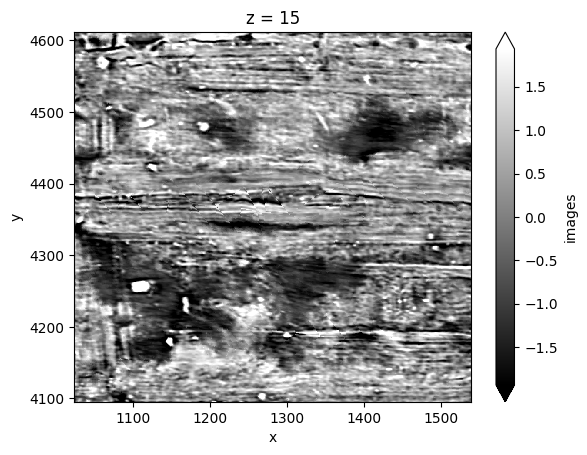

In [63]:
x_start = 1024
y_start = 4096
size = 516
dd =dsn.images.isel(z=15, x=slice(x_start,  x_start + size), y=slice(y_start, y_start + size))
dd.plot.imshow(robust=True, cmap='gray')

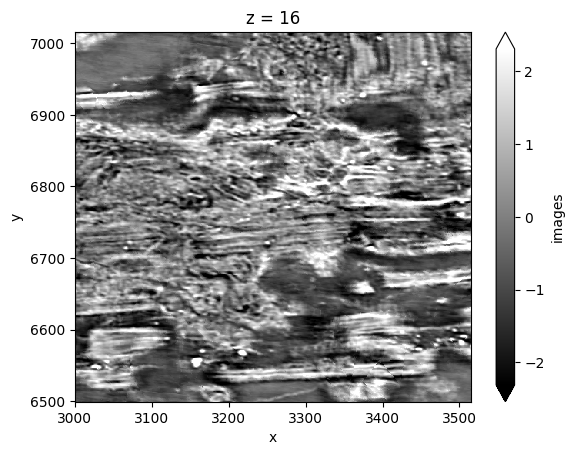

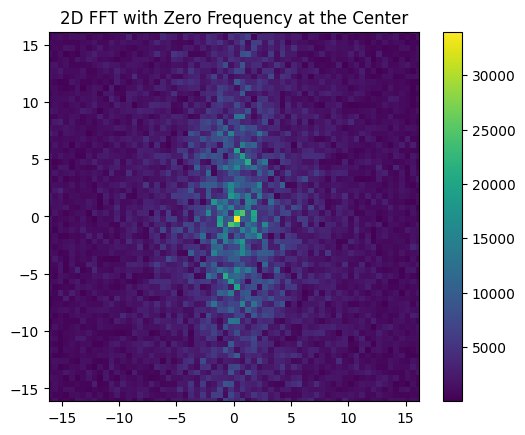

In [79]:
x_start = 3000
y_start = 6500
size = 516
dd =dsn.images.isel(z=16, x=slice(x_start,  x_start + size), y=slice(y_start, y_start + size))
dd.plot.imshow(robust=True, cmap='gray')
plt.show()
# Perform a 2D FFT on the data
fft_data = np.fft.fft2(dd)

# Shift the zero frequency to the center
fft_data_shifted = np.fft.fftshift(fft_data)

# Calculate the magnitude of the shifted FFT
magnitude = np.abs(fft_data_shifted)

# Display the result
# plt.imshow(np.log10(1 + magnitude), extent=(-128, 128, -128, 128), cmap='viridis')
plt.imshow(magnitude, extent=(-128, 128, -128, 128), cmap='viridis')
zoom = 32
plt.xlim(-size/zoom, size/zoom)
plt.ylim(-size/zoom, size/zoom)
plt.colorbar()
plt.title('2D FFT with Zero Frequency at the Center')
plt.show()